In [2]:
# source: https://github.com/lazyprogrammer/facial-expression-recognition
from __future__ import print_function, division
from builtins import range
# Note: you may need to update your version of future
# sudo pip install -U future

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [3]:
def init_weight_and_bias(M1, M2):
    W = np.random.randn(M1, M2) / np.sqrt(M1)
    b = np.zeros(M2)
    return W.astype(np.float32), b.astype(np.float32)


def init_filter(shape, poolsz):
    w = np.random.randn(*shape) / np.sqrt(np.prod(shape[1:]) + shape[0]*np.prod(shape[2:] / np.prod(poolsz)))
    return w.astype(np.float32)


def relu(x):
    return x * (x > 0)


def sigmoid(A):
    return 1 / (1 + np.exp(-A))


def softmax(A):
    expA = np.exp(A)
    return expA / expA.sum(axis=1, keepdims=True)


def sigmoid_cost(T, Y):
    return -(T*np.log(Y) + (1-T)*np.log(1-Y)).sum()


def cost(T, Y):
    return -(T*np.log(Y)).sum()


def cost2(T, Y):
    # same as cost(), just uses the targets to index Y
    # instead of multiplying by a large indicator matrix with mostly 0s
    N = len(T)
    return -np.log(Y[np.arange(N), T]).mean()


def error_rate(targets, predictions):
    return np.mean(targets != predictions)


def y2indicator(y):
    N = len(y)
    K = len(set(y))
    ind = np.zeros((N, K))
    for i in range(N):
        ind[i, y[i]] = 1
    return ind


def getData(balance_ones=True):
    # images are 48x48 = 2304 size vectors
    # N = 35887
    Y = []
    X = []
    first = True
    for line in open('cnn_data/fer2013/fer2013.csv'):
        if first:
            first = False
        else:
            row = line.split(',')
            Y.append(int(row[0]))
            X.append([int(p) for p in row[1].split()])

    X, Y = np.array(X) / 255.0, np.array(Y)

    if balance_ones:
        # balance the 1 class
        X0, Y0 = X[Y!=1, :], Y[Y!=1]
        X1 = X[Y==1, :]
        X1 = np.repeat(X1, 9, axis=0)
        X = np.vstack([X0, X1])
        Y = np.concatenate((Y0, [1]*len(X1)))

    return X, Y


def getImageData():
    X, Y = getData()
    N, D = X.shape
    d = int(np.sqrt(D))
    X = X.reshape(N, 1, d, d)
    return X, Y


def getBinaryData():
    Y = []
    X = []
    first = True
    for line in open('fer2013.csv'):
        if first:
            first = False
        else:
            row = line.split(',')
            y = int(row[0])
            if y == 0 or y == 1:
                Y.append(y)
                X.append([int(p) for p in row[1].split()])
    return np.array(X) / 255.0, np.array(Y)


def crossValidation(model, X, Y, K=5):
    # split data into K parts
    X, Y = shuffle(X, Y)
    sz = len(Y) // K
    errors = []
    for k in range(K):
        xtr = np.concatenate([ X[:k*sz, :], X[(k*sz + sz):, :] ])
        ytr = np.concatenate([ Y[:k*sz], Y[(k*sz + sz):] ])
        xte = X[k*sz:(k*sz + sz), :]
        yte = Y[k*sz:(k*sz + sz)]

        model.fit(xtr, ytr)
        err = model.score(xte, yte)
        errors.append(err)
    print("errors:", errors)
    return np.mean(errors)

In [4]:
label_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

In [ ]:
X, Y = getData(balance_ones=False)

while True:
    for i in range(7):
        x, y = X[Y==i], Y[Y==i]
        N = len(y)
        j = np.random.choice(N)
        plt.imshow(x[j].reshape(48, 48), cmap='gray')
        plt.title(label_map[y[j]])
        plt.show()
    prompt = input('Quit? Enter Y:\n')
    if prompt == 'Y' or prompt == 'y':
        break

In [5]:
# Theano version ann
import theano
import theano.tensor as T

class ANNTheanoHiddenLayer(object):
    def __init__(self, M1, M2, an_id):
        self.id = an_id
        self.M1 = M1
        self.M2 = M2
        W, b = init_weight_and_bias(M1, M2)
        self.W = theano.shared(W, 'W_%s' % self.id)
        self.b = theano.shared(b, 'b_%s' % self.id)
        self.params = [self.W, self.b]

    def forward(self, X):
        return relu(X.dot(self.W) + self.b)

class ANNTheano(object):
    def __init__(self, hidden_layer_sizes):
        self.hidden_layer_sizes = hidden_layer_sizes

    def fit(self, X, Y, learning_rate=10e-7, mu=0.99, decay=0.999, reg=10e-12, eps=10e-10, epochs=400, batch_sz=100, show_fig=False):
        learning_rate = np.float32(learning_rate)
        mu = np.float32(mu)
        decay = np.float32(decay)
        reg = np.float32(reg)
        eps = np.float32(eps)

        # make a validation set
        X, Y = shuffle(X, Y)
        X = X.astype(np.float32)
        Y = Y.astype(np.int32)
        Xvalid, Yvalid = X[-1000:], Y[-1000:]
        X, Y = X[:-1000], Y[:-1000]

        # initialize hidden layers
        N, D = X.shape
        K = len(set(Y))
        self.hidden_layers = []
        M1 = D
        count = 0
        for M2 in self.hidden_layer_sizes:
            h = ANNTheanoHiddenLayer(M1, M2, count)
            self.hidden_layers.append(h)
            M1 = M2
            count += 1
        W, b = init_weight_and_bias(M1, K)
        self.W = theano.shared(W, 'W_logreg')
        self.b = theano.shared(b, 'b_logreg')

        # collect params for later use
        self.params = [self.W, self.b]
        for h in self.hidden_layers:
            self.params += h.params

        # for momentum
        dparams = [theano.shared(np.zeros(p.get_value().shape, dtype=np.float32)) for p in self.params]

        # for rmsprop
        cache = [theano.shared(np.zeros(p.get_value().shape, dtype=np.float32)) for p in self.params]

        # set up theano functions and variables
        thX = T.fmatrix('X')
        thY = T.ivector('Y')
        pY = self.th_forward(thX)

        rcost = reg*T.sum([(p*p).sum() for p in self.params])
        cost = -T.mean(T.log(pY[T.arange(thY.shape[0]), thY])) + rcost
        prediction = self.th_predict(thX)

        # actual prediction function
        self.predict_op = theano.function(inputs=[thX], outputs=prediction)
        cost_predict_op = theano.function(inputs=[thX, thY], outputs=[cost, prediction])

        updates = [
            (c, decay*c + (np.float32(1)-decay)*T.grad(cost, p)*T.grad(cost, p)) for p, c in zip(self.params, cache)
        ] + [
            (p, p + mu*dp - learning_rate*T.grad(cost, p)/T.sqrt(c + eps)) for p, c, dp in zip(self.params, cache, dparams)
        ] + [
            (dp, mu*dp - learning_rate*T.grad(cost, p)/T.sqrt(c + eps)) for p, c, dp in zip(self.params, cache, dparams)
        ]

        # momentum only
        # updates = [
        #     (p, p + mu*dp - learning_rate*T.grad(cost, p)) for p, dp in zip(self.params, dparams)
        # ] + [
        #     (dp, mu*dp - learning_rate*T.grad(cost, p)) for p, dp in zip(self.params, dparams)
        # ]

        train_op = theano.function(
            inputs=[thX, thY],
            updates=updates
        )

        n_batches = N // batch_sz
        costs = []
        for i in range(epochs):
            X, Y = shuffle(X, Y)
            for j in range(n_batches):
                Xbatch = X[j*batch_sz:(j*batch_sz+batch_sz)]
                Ybatch = Y[j*batch_sz:(j*batch_sz+batch_sz)]

                train_op(Xbatch, Ybatch)

                if j % 20 == 0:
                    c, p = cost_predict_op(Xvalid, Yvalid)
                    costs.append(c)
                    e = error_rate(Yvalid, p)
                    print("i:", i, "j:", j, "nb:", n_batches, "cost:", c, "error rate:", e)
        
        if show_fig:
            plt.plot(costs)
            plt.show()

    def th_forward(self, X):
        Z = X
        for h in self.hidden_layers:
            Z = h.forward(Z)
        return T.nnet.softmax(Z.dot(self.W) + self.b)

    def th_predict(self, X):
        pY = self.th_forward(X)
        return T.argmax(pY, axis=1)

    def predict(self, X):
        return self.predict_op(X)

i: 0 j: 0 nb: 392 cost: 2.1370458602905273 error rate: 0.768
i: 0 j: 20 nb: 392 cost: 2.005582809448242 error rate: 0.806
i: 0 j: 40 nb: 392 cost: 2.188565969467163 error rate: 0.816
i: 0 j: 60 nb: 392 cost: 2.2104411125183105 error rate: 0.853
i: 0 j: 80 nb: 392 cost: 2.2328453063964844 error rate: 0.783
i: 0 j: 100 nb: 392 cost: 2.469282627105713 error rate: 0.832
i: 0 j: 120 nb: 392 cost: 2.447310209274292 error rate: 0.829
i: 0 j: 140 nb: 392 cost: 2.2702643871307373 error rate: 0.827
i: 0 j: 160 nb: 392 cost: 2.0548675060272217 error rate: 0.75
i: 0 j: 180 nb: 392 cost: 2.290888786315918 error rate: 0.766
i: 0 j: 200 nb: 392 cost: 2.268639087677002 error rate: 0.766
i: 0 j: 220 nb: 392 cost: 2.3882291316986084 error rate: 0.761
i: 0 j: 240 nb: 392 cost: 2.0004286766052246 error rate: 0.765
i: 0 j: 260 nb: 392 cost: 2.19752836227417 error rate: 0.819
i: 0 j: 280 nb: 392 cost: 2.1284868717193604 error rate: 0.833
i: 0 j: 300 nb: 392 cost: 2.26497745513916 error rate: 0.789
i: 0 j: 3

i: 6 j: 260 nb: 392 cost: 1.7286908626556396 error rate: 0.659
i: 6 j: 280 nb: 392 cost: 1.7867591381072998 error rate: 0.675
i: 6 j: 300 nb: 392 cost: 1.711499810218811 error rate: 0.644
i: 6 j: 320 nb: 392 cost: 1.7180293798446655 error rate: 0.655
i: 6 j: 340 nb: 392 cost: 1.7522538900375366 error rate: 0.669
i: 6 j: 360 nb: 392 cost: 1.6943830251693726 error rate: 0.642
i: 6 j: 380 nb: 392 cost: 1.7377151250839233 error rate: 0.663
i: 7 j: 0 nb: 392 cost: 1.7054258584976196 error rate: 0.648
i: 7 j: 20 nb: 392 cost: 1.7129651308059692 error rate: 0.655
i: 7 j: 40 nb: 392 cost: 1.737932562828064 error rate: 0.658
i: 7 j: 60 nb: 392 cost: 1.7178432941436768 error rate: 0.651
i: 7 j: 80 nb: 392 cost: 1.7128214836120605 error rate: 0.635
i: 7 j: 100 nb: 392 cost: 1.7006981372833252 error rate: 0.648
i: 7 j: 120 nb: 392 cost: 1.6902896165847778 error rate: 0.636
i: 7 j: 140 nb: 392 cost: 1.6871517896652222 error rate: 0.628
i: 7 j: 160 nb: 392 cost: 1.6811084747314453 error rate: 0.634


i: 13 j: 80 nb: 392 cost: 1.6059446334838867 error rate: 0.588
i: 13 j: 100 nb: 392 cost: 1.6345531940460205 error rate: 0.611
i: 13 j: 120 nb: 392 cost: 1.5920796394348145 error rate: 0.608
i: 13 j: 140 nb: 392 cost: 1.5815283060073853 error rate: 0.585
i: 13 j: 160 nb: 392 cost: 1.6191860437393188 error rate: 0.604
i: 13 j: 180 nb: 392 cost: 1.5924571752548218 error rate: 0.593
i: 13 j: 200 nb: 392 cost: 1.615071177482605 error rate: 0.594
i: 13 j: 220 nb: 392 cost: 1.6175897121429443 error rate: 0.6
i: 13 j: 240 nb: 392 cost: 1.5911133289337158 error rate: 0.58
i: 13 j: 260 nb: 392 cost: 1.6086586713790894 error rate: 0.592
i: 13 j: 280 nb: 392 cost: 1.583262324333191 error rate: 0.589
i: 13 j: 300 nb: 392 cost: 1.5998811721801758 error rate: 0.593
i: 13 j: 320 nb: 392 cost: 1.5748686790466309 error rate: 0.585
i: 13 j: 340 nb: 392 cost: 1.603478193283081 error rate: 0.594
i: 13 j: 360 nb: 392 cost: 1.5726972818374634 error rate: 0.587
i: 13 j: 380 nb: 392 cost: 1.59003484249115 err

i: 19 j: 280 nb: 392 cost: 1.5146007537841797 error rate: 0.568
i: 19 j: 300 nb: 392 cost: 1.5211679935455322 error rate: 0.563
i: 19 j: 320 nb: 392 cost: 1.5175952911376953 error rate: 0.564
i: 19 j: 340 nb: 392 cost: 1.5165389776229858 error rate: 0.568
i: 19 j: 360 nb: 392 cost: 1.4959280490875244 error rate: 0.545
i: 19 j: 380 nb: 392 cost: 1.4994843006134033 error rate: 0.552
i: 20 j: 0 nb: 392 cost: 1.5200165510177612 error rate: 0.565
i: 20 j: 20 nb: 392 cost: 1.5281085968017578 error rate: 0.567
i: 20 j: 40 nb: 392 cost: 1.5708887577056885 error rate: 0.585
i: 20 j: 60 nb: 392 cost: 1.6021629571914673 error rate: 0.596
i: 20 j: 80 nb: 392 cost: 1.5417581796646118 error rate: 0.582
i: 20 j: 100 nb: 392 cost: 1.516800880432129 error rate: 0.576
i: 20 j: 120 nb: 392 cost: 1.540860891342163 error rate: 0.576
i: 20 j: 140 nb: 392 cost: 1.5056560039520264 error rate: 0.569
i: 20 j: 160 nb: 392 cost: 1.511270523071289 error rate: 0.563
i: 20 j: 180 nb: 392 cost: 1.5240861177444458 err

i: 26 j: 80 nb: 392 cost: 1.493393898010254 error rate: 0.564
i: 26 j: 100 nb: 392 cost: 1.4671965837478638 error rate: 0.55
i: 26 j: 120 nb: 392 cost: 1.4712741374969482 error rate: 0.557
i: 26 j: 140 nb: 392 cost: 1.4569157361984253 error rate: 0.547
i: 26 j: 160 nb: 392 cost: 1.45457124710083 error rate: 0.551
i: 26 j: 180 nb: 392 cost: 1.4668482542037964 error rate: 0.567
i: 26 j: 200 nb: 392 cost: 1.4467557668685913 error rate: 0.547
i: 26 j: 220 nb: 392 cost: 1.4354703426361084 error rate: 0.543
i: 26 j: 240 nb: 392 cost: 1.4630368947982788 error rate: 0.546
i: 26 j: 260 nb: 392 cost: 1.491175651550293 error rate: 0.559
i: 26 j: 280 nb: 392 cost: 1.5042245388031006 error rate: 0.572
i: 26 j: 300 nb: 392 cost: 1.446946382522583 error rate: 0.542
i: 26 j: 320 nb: 392 cost: 1.476405143737793 error rate: 0.562
i: 26 j: 340 nb: 392 cost: 1.5113083124160767 error rate: 0.578
i: 26 j: 360 nb: 392 cost: 1.4877833127975464 error rate: 0.57
i: 26 j: 380 nb: 392 cost: 1.4768993854522705 err

i: 32 j: 280 nb: 392 cost: 1.4052388668060303 error rate: 0.548
i: 32 j: 300 nb: 392 cost: 1.416844129562378 error rate: 0.519
i: 32 j: 320 nb: 392 cost: 1.3893890380859375 error rate: 0.534
i: 32 j: 340 nb: 392 cost: 1.4041614532470703 error rate: 0.527
i: 32 j: 360 nb: 392 cost: 1.4120640754699707 error rate: 0.526
i: 32 j: 380 nb: 392 cost: 1.4184433221817017 error rate: 0.527
i: 33 j: 0 nb: 392 cost: 1.3997079133987427 error rate: 0.521
i: 33 j: 20 nb: 392 cost: 1.4201509952545166 error rate: 0.537
i: 33 j: 40 nb: 392 cost: 1.4173165559768677 error rate: 0.539
i: 33 j: 60 nb: 392 cost: 1.4184602499008179 error rate: 0.533
i: 33 j: 80 nb: 392 cost: 1.4045730829238892 error rate: 0.534
i: 33 j: 100 nb: 392 cost: 1.4363183975219727 error rate: 0.559
i: 33 j: 120 nb: 392 cost: 1.3955520391464233 error rate: 0.535
i: 33 j: 140 nb: 392 cost: 1.427635669708252 error rate: 0.531
i: 33 j: 160 nb: 392 cost: 1.452298641204834 error rate: 0.545
i: 33 j: 180 nb: 392 cost: 1.4381487369537354 err

i: 39 j: 80 nb: 392 cost: 1.3574880361557007 error rate: 0.522
i: 39 j: 100 nb: 392 cost: 1.3546669483184814 error rate: 0.527
i: 39 j: 120 nb: 392 cost: 1.370140552520752 error rate: 0.521
i: 39 j: 140 nb: 392 cost: 1.3707979917526245 error rate: 0.522
i: 39 j: 160 nb: 392 cost: 1.420545220375061 error rate: 0.531
i: 39 j: 180 nb: 392 cost: 1.3842253684997559 error rate: 0.524
i: 39 j: 200 nb: 392 cost: 1.3810518980026245 error rate: 0.51
i: 39 j: 220 nb: 392 cost: 1.4080415964126587 error rate: 0.526
i: 39 j: 240 nb: 392 cost: 1.3856801986694336 error rate: 0.519
i: 39 j: 260 nb: 392 cost: 1.4262311458587646 error rate: 0.543
i: 39 j: 280 nb: 392 cost: 1.4398406744003296 error rate: 0.539
i: 39 j: 300 nb: 392 cost: 1.3918575048446655 error rate: 0.518
i: 39 j: 320 nb: 392 cost: 1.3975664377212524 error rate: 0.524
i: 39 j: 340 nb: 392 cost: 1.4109447002410889 error rate: 0.538
i: 39 j: 360 nb: 392 cost: 1.3872153759002686 error rate: 0.527
i: 39 j: 380 nb: 392 cost: 1.385776281356811

i: 45 j: 280 nb: 392 cost: 1.3673828840255737 error rate: 0.509
i: 45 j: 300 nb: 392 cost: 1.3738114833831787 error rate: 0.515
i: 45 j: 320 nb: 392 cost: 1.418596625328064 error rate: 0.524
i: 45 j: 340 nb: 392 cost: 1.3772757053375244 error rate: 0.526
i: 45 j: 360 nb: 392 cost: 1.3952012062072754 error rate: 0.521
i: 45 j: 380 nb: 392 cost: 1.4489434957504272 error rate: 0.527
i: 46 j: 0 nb: 392 cost: 1.4278676509857178 error rate: 0.527
i: 46 j: 20 nb: 392 cost: 1.4148335456848145 error rate: 0.521
i: 46 j: 40 nb: 392 cost: 1.4000039100646973 error rate: 0.518
i: 46 j: 60 nb: 392 cost: 1.3894118070602417 error rate: 0.518
i: 46 j: 80 nb: 392 cost: 1.4144738912582397 error rate: 0.516
i: 46 j: 100 nb: 392 cost: 1.3941818475723267 error rate: 0.527
i: 46 j: 120 nb: 392 cost: 1.3713852167129517 error rate: 0.512
i: 46 j: 140 nb: 392 cost: 1.386597990989685 error rate: 0.5
i: 46 j: 160 nb: 392 cost: 1.3892301321029663 error rate: 0.498
i: 46 j: 180 nb: 392 cost: 1.3935737609863281 erro

i: 52 j: 80 nb: 392 cost: 1.388962745666504 error rate: 0.503
i: 52 j: 100 nb: 392 cost: 1.4153997898101807 error rate: 0.51
i: 52 j: 120 nb: 392 cost: 1.4507920742034912 error rate: 0.529
i: 52 j: 140 nb: 392 cost: 1.4127473831176758 error rate: 0.51
i: 52 j: 160 nb: 392 cost: 1.4118385314941406 error rate: 0.52
i: 52 j: 180 nb: 392 cost: 1.389354944229126 error rate: 0.506
i: 52 j: 200 nb: 392 cost: 1.3843886852264404 error rate: 0.505
i: 52 j: 220 nb: 392 cost: 1.458390474319458 error rate: 0.502
i: 52 j: 240 nb: 392 cost: 1.4009631872177124 error rate: 0.516
i: 52 j: 260 nb: 392 cost: 1.4082248210906982 error rate: 0.512
i: 52 j: 280 nb: 392 cost: 1.432856798171997 error rate: 0.513
i: 52 j: 300 nb: 392 cost: 1.4267456531524658 error rate: 0.522
i: 52 j: 320 nb: 392 cost: 1.4123919010162354 error rate: 0.519
i: 52 j: 340 nb: 392 cost: 1.4026461839675903 error rate: 0.51
i: 52 j: 360 nb: 392 cost: 1.42776620388031 error rate: 0.514
i: 52 j: 380 nb: 392 cost: 1.4144251346588135 error

i: 58 j: 280 nb: 392 cost: 1.4470089673995972 error rate: 0.525
i: 58 j: 300 nb: 392 cost: 1.446461796760559 error rate: 0.512
i: 58 j: 320 nb: 392 cost: 1.4588793516159058 error rate: 0.506
i: 58 j: 340 nb: 392 cost: 1.42972993850708 error rate: 0.51
i: 58 j: 360 nb: 392 cost: 1.4506748914718628 error rate: 0.519
i: 58 j: 380 nb: 392 cost: 1.4248672723770142 error rate: 0.502
i: 59 j: 0 nb: 392 cost: 1.4191129207611084 error rate: 0.506
i: 59 j: 20 nb: 392 cost: 1.4187806844711304 error rate: 0.491
i: 59 j: 40 nb: 392 cost: 1.4240169525146484 error rate: 0.515
i: 59 j: 60 nb: 392 cost: 1.430472493171692 error rate: 0.502
i: 59 j: 80 nb: 392 cost: 1.4231367111206055 error rate: 0.506
i: 59 j: 100 nb: 392 cost: 1.4194508790969849 error rate: 0.505
i: 59 j: 120 nb: 392 cost: 1.4323865175247192 error rate: 0.506
i: 59 j: 140 nb: 392 cost: 1.4407639503479004 error rate: 0.507
i: 59 j: 160 nb: 392 cost: 1.4166433811187744 error rate: 0.5
i: 59 j: 180 nb: 392 cost: 1.4380701780319214 error r

i: 65 j: 80 nb: 392 cost: 1.4621435403823853 error rate: 0.505
i: 65 j: 100 nb: 392 cost: 1.498009204864502 error rate: 0.511
i: 65 j: 120 nb: 392 cost: 1.48532235622406 error rate: 0.513
i: 65 j: 140 nb: 392 cost: 1.4712847471237183 error rate: 0.505
i: 65 j: 160 nb: 392 cost: 1.4518146514892578 error rate: 0.506
i: 65 j: 180 nb: 392 cost: 1.478976845741272 error rate: 0.509
i: 65 j: 200 nb: 392 cost: 1.4732506275177002 error rate: 0.515
i: 65 j: 220 nb: 392 cost: 1.4763495922088623 error rate: 0.499
i: 65 j: 240 nb: 392 cost: 1.4877671003341675 error rate: 0.501
i: 65 j: 260 nb: 392 cost: 1.501598834991455 error rate: 0.51
i: 65 j: 280 nb: 392 cost: 1.4767961502075195 error rate: 0.486
i: 65 j: 300 nb: 392 cost: 1.4826658964157104 error rate: 0.52
i: 65 j: 320 nb: 392 cost: 1.4963774681091309 error rate: 0.519
i: 65 j: 340 nb: 392 cost: 1.4865585565567017 error rate: 0.518
i: 65 j: 360 nb: 392 cost: 1.449643611907959 error rate: 0.495
i: 65 j: 380 nb: 392 cost: 1.4510548114776611 err

i: 71 j: 280 nb: 392 cost: 1.5505539178848267 error rate: 0.509
i: 71 j: 300 nb: 392 cost: 1.576850175857544 error rate: 0.509
i: 71 j: 320 nb: 392 cost: 1.5547410249710083 error rate: 0.498
i: 71 j: 340 nb: 392 cost: 1.5493943691253662 error rate: 0.499
i: 71 j: 360 nb: 392 cost: 1.52492094039917 error rate: 0.485
i: 71 j: 380 nb: 392 cost: 1.537621021270752 error rate: 0.499
i: 72 j: 0 nb: 392 cost: 1.524914026260376 error rate: 0.507
i: 72 j: 20 nb: 392 cost: 1.5442759990692139 error rate: 0.505
i: 72 j: 40 nb: 392 cost: 1.545840859413147 error rate: 0.503
i: 72 j: 60 nb: 392 cost: 1.531203031539917 error rate: 0.501
i: 72 j: 80 nb: 392 cost: 1.509255290031433 error rate: 0.5
i: 72 j: 100 nb: 392 cost: 1.5132941007614136 error rate: 0.492
i: 72 j: 120 nb: 392 cost: 1.529168725013733 error rate: 0.504
i: 72 j: 140 nb: 392 cost: 1.5690659284591675 error rate: 0.526
i: 72 j: 160 nb: 392 cost: 1.5311850309371948 error rate: 0.508
i: 72 j: 180 nb: 392 cost: 1.5656026601791382 error rate:

i: 78 j: 80 nb: 392 cost: 1.6118874549865723 error rate: 0.494
i: 78 j: 100 nb: 392 cost: 1.6125186681747437 error rate: 0.496
i: 78 j: 120 nb: 392 cost: 1.6175771951675415 error rate: 0.519
i: 78 j: 140 nb: 392 cost: 1.6290444135665894 error rate: 0.517
i: 78 j: 160 nb: 392 cost: 1.6141769886016846 error rate: 0.517
i: 78 j: 180 nb: 392 cost: 1.5863045454025269 error rate: 0.502
i: 78 j: 200 nb: 392 cost: 1.5943490266799927 error rate: 0.512
i: 78 j: 220 nb: 392 cost: 1.5667387247085571 error rate: 0.494
i: 78 j: 240 nb: 392 cost: 1.6083842515945435 error rate: 0.503
i: 78 j: 260 nb: 392 cost: 1.6035957336425781 error rate: 0.496
i: 78 j: 280 nb: 392 cost: 1.6298444271087646 error rate: 0.513
i: 78 j: 300 nb: 392 cost: 1.6529744863510132 error rate: 0.521
i: 78 j: 320 nb: 392 cost: 1.5893967151641846 error rate: 0.499
i: 78 j: 340 nb: 392 cost: 1.5862834453582764 error rate: 0.49
i: 78 j: 360 nb: 392 cost: 1.5708444118499756 error rate: 0.481
i: 78 j: 380 nb: 392 cost: 1.5955326557159

i: 84 j: 280 nb: 392 cost: 1.6878300905227661 error rate: 0.508
i: 84 j: 300 nb: 392 cost: 1.7014650106430054 error rate: 0.509
i: 84 j: 320 nb: 392 cost: 1.6807883977890015 error rate: 0.51
i: 84 j: 340 nb: 392 cost: 1.638999342918396 error rate: 0.507
i: 84 j: 360 nb: 392 cost: 1.6638832092285156 error rate: 0.5
i: 84 j: 380 nb: 392 cost: 1.6470400094985962 error rate: 0.493
i: 85 j: 0 nb: 392 cost: 1.6651670932769775 error rate: 0.5
i: 85 j: 20 nb: 392 cost: 1.6835010051727295 error rate: 0.508
i: 85 j: 40 nb: 392 cost: 1.7012540102005005 error rate: 0.506
i: 85 j: 60 nb: 392 cost: 1.7122410535812378 error rate: 0.51
i: 85 j: 80 nb: 392 cost: 1.7148569822311401 error rate: 0.497
i: 85 j: 100 nb: 392 cost: 1.6619528532028198 error rate: 0.495
i: 85 j: 120 nb: 392 cost: 1.6577178239822388 error rate: 0.491
i: 85 j: 140 nb: 392 cost: 1.6446561813354492 error rate: 0.494
i: 85 j: 160 nb: 392 cost: 1.6740485429763794 error rate: 0.508
i: 85 j: 180 nb: 392 cost: 1.6767998933792114 error r

i: 91 j: 80 nb: 392 cost: 1.7704741954803467 error rate: 0.503
i: 91 j: 100 nb: 392 cost: 1.826189398765564 error rate: 0.515
i: 91 j: 120 nb: 392 cost: 1.8337520360946655 error rate: 0.508
i: 91 j: 140 nb: 392 cost: 1.8085060119628906 error rate: 0.503
i: 91 j: 160 nb: 392 cost: 1.7967231273651123 error rate: 0.514
i: 91 j: 180 nb: 392 cost: 1.7595170736312866 error rate: 0.489
i: 91 j: 200 nb: 392 cost: 1.7556153535842896 error rate: 0.492
i: 91 j: 220 nb: 392 cost: 1.7400333881378174 error rate: 0.502
i: 91 j: 240 nb: 392 cost: 1.804977297782898 error rate: 0.516
i: 91 j: 260 nb: 392 cost: 1.79517662525177 error rate: 0.5
i: 91 j: 280 nb: 392 cost: 1.8005099296569824 error rate: 0.505
i: 91 j: 300 nb: 392 cost: 1.8203994035720825 error rate: 0.517
i: 91 j: 320 nb: 392 cost: 1.7522499561309814 error rate: 0.512
i: 91 j: 340 nb: 392 cost: 1.7706828117370605 error rate: 0.491
i: 91 j: 360 nb: 392 cost: 1.7815021276474 error rate: 0.488
i: 91 j: 380 nb: 392 cost: 1.7738890647888184 erro

i: 97 j: 280 nb: 392 cost: 1.846193790435791 error rate: 0.501
i: 97 j: 300 nb: 392 cost: 1.8502264022827148 error rate: 0.492
i: 97 j: 320 nb: 392 cost: 1.851531744003296 error rate: 0.477
i: 97 j: 340 nb: 392 cost: 1.8329675197601318 error rate: 0.497
i: 97 j: 360 nb: 392 cost: 1.8688396215438843 error rate: 0.499
i: 97 j: 380 nb: 392 cost: 1.8989006280899048 error rate: 0.499
i: 98 j: 0 nb: 392 cost: 1.8748277425765991 error rate: 0.504
i: 98 j: 20 nb: 392 cost: 1.8747519254684448 error rate: 0.51
i: 98 j: 40 nb: 392 cost: 1.920391321182251 error rate: 0.501
i: 98 j: 60 nb: 392 cost: 1.860459566116333 error rate: 0.492
i: 98 j: 80 nb: 392 cost: 1.8731478452682495 error rate: 0.493
i: 98 j: 100 nb: 392 cost: 1.893074870109558 error rate: 0.502
i: 98 j: 120 nb: 392 cost: 1.8892139196395874 error rate: 0.506
i: 98 j: 140 nb: 392 cost: 1.8913644552230835 error rate: 0.501
i: 98 j: 160 nb: 392 cost: 1.8757119178771973 error rate: 0.508
i: 98 j: 180 nb: 392 cost: 1.8891880512237549 error 

i: 104 j: 40 nb: 392 cost: 1.9592887163162231 error rate: 0.495
i: 104 j: 60 nb: 392 cost: 2.028257369995117 error rate: 0.504
i: 104 j: 80 nb: 392 cost: 1.96293044090271 error rate: 0.492
i: 104 j: 100 nb: 392 cost: 1.9951521158218384 error rate: 0.493
i: 104 j: 120 nb: 392 cost: 1.9654383659362793 error rate: 0.491
i: 104 j: 140 nb: 392 cost: 1.9564164876937866 error rate: 0.48
i: 104 j: 160 nb: 392 cost: 2.0042450428009033 error rate: 0.498
i: 104 j: 180 nb: 392 cost: 1.9080759286880493 error rate: 0.48
i: 104 j: 200 nb: 392 cost: 1.9492745399475098 error rate: 0.488
i: 104 j: 220 nb: 392 cost: 2.0309879779815674 error rate: 0.498
i: 104 j: 240 nb: 392 cost: 1.989490270614624 error rate: 0.5
i: 104 j: 260 nb: 392 cost: 2.016834020614624 error rate: 0.497
i: 104 j: 280 nb: 392 cost: 1.9641467332839966 error rate: 0.494
i: 104 j: 300 nb: 392 cost: 2.0997352600097656 error rate: 0.5
i: 104 j: 320 nb: 392 cost: 2.017242431640625 error rate: 0.495
i: 104 j: 340 nb: 392 cost: 1.9784409999

i: 110 j: 200 nb: 392 cost: 2.0945942401885986 error rate: 0.492
i: 110 j: 220 nb: 392 cost: 2.133626937866211 error rate: 0.492
i: 110 j: 240 nb: 392 cost: 2.0782220363616943 error rate: 0.508
i: 110 j: 260 nb: 392 cost: 2.1319398880004883 error rate: 0.511
i: 110 j: 280 nb: 392 cost: 2.1307411193847656 error rate: 0.501
i: 110 j: 300 nb: 392 cost: 2.1246466636657715 error rate: 0.497
i: 110 j: 320 nb: 392 cost: 2.2118589878082275 error rate: 0.507
i: 110 j: 340 nb: 392 cost: 2.153615713119507 error rate: 0.499
i: 110 j: 360 nb: 392 cost: 2.1764609813690186 error rate: 0.51
i: 110 j: 380 nb: 392 cost: 2.1447956562042236 error rate: 0.512
i: 111 j: 0 nb: 392 cost: 2.3219127655029297 error rate: 0.532
i: 111 j: 20 nb: 392 cost: 2.2192094326019287 error rate: 0.511
i: 111 j: 40 nb: 392 cost: 2.1923389434814453 error rate: 0.497
i: 111 j: 60 nb: 392 cost: 2.133474349975586 error rate: 0.499
i: 111 j: 80 nb: 392 cost: 2.1595776081085205 error rate: 0.523
i: 111 j: 100 nb: 392 cost: 2.19350

i: 116 j: 360 nb: 392 cost: 2.2049739360809326 error rate: 0.486
i: 116 j: 380 nb: 392 cost: 2.2372629642486572 error rate: 0.49
i: 117 j: 0 nb: 392 cost: 2.28729510307312 error rate: 0.506
i: 117 j: 20 nb: 392 cost: 2.203582763671875 error rate: 0.495
i: 117 j: 40 nb: 392 cost: 2.189901828765869 error rate: 0.497
i: 117 j: 60 nb: 392 cost: 2.200242280960083 error rate: 0.498
i: 117 j: 80 nb: 392 cost: 2.1533079147338867 error rate: 0.48
i: 117 j: 100 nb: 392 cost: 2.199679374694824 error rate: 0.492
i: 117 j: 120 nb: 392 cost: 2.1905646324157715 error rate: 0.483
i: 117 j: 140 nb: 392 cost: 2.189934730529785 error rate: 0.488
i: 117 j: 160 nb: 392 cost: 2.2162957191467285 error rate: 0.489
i: 117 j: 180 nb: 392 cost: 2.2335684299468994 error rate: 0.496
i: 117 j: 200 nb: 392 cost: 2.2335264682769775 error rate: 0.495
i: 117 j: 220 nb: 392 cost: 2.247281551361084 error rate: 0.485
i: 117 j: 240 nb: 392 cost: 2.2183985710144043 error rate: 0.494
i: 117 j: 260 nb: 392 cost: 2.18128538131

i: 123 j: 120 nb: 392 cost: 2.2801878452301025 error rate: 0.485
i: 123 j: 140 nb: 392 cost: 2.375605583190918 error rate: 0.495
i: 123 j: 160 nb: 392 cost: 2.3631718158721924 error rate: 0.498
i: 123 j: 180 nb: 392 cost: 2.3567371368408203 error rate: 0.507
i: 123 j: 200 nb: 392 cost: 2.4238696098327637 error rate: 0.514
i: 123 j: 220 nb: 392 cost: 2.3560659885406494 error rate: 0.502
i: 123 j: 240 nb: 392 cost: 2.403505802154541 error rate: 0.503
i: 123 j: 260 nb: 392 cost: 2.3556394577026367 error rate: 0.503
i: 123 j: 280 nb: 392 cost: 2.2789573669433594 error rate: 0.481
i: 123 j: 300 nb: 392 cost: 2.3253469467163086 error rate: 0.493
i: 123 j: 320 nb: 392 cost: 2.3318796157836914 error rate: 0.498
i: 123 j: 340 nb: 392 cost: 2.3272712230682373 error rate: 0.506
i: 123 j: 360 nb: 392 cost: 2.4077703952789307 error rate: 0.511
i: 123 j: 380 nb: 392 cost: 2.347621202468872 error rate: 0.503
i: 124 j: 0 nb: 392 cost: 2.3806142807006836 error rate: 0.503
i: 124 j: 20 nb: 392 cost: 2.3

i: 129 j: 280 nb: 392 cost: 2.4093017578125 error rate: 0.48
i: 129 j: 300 nb: 392 cost: 2.3859848976135254 error rate: 0.487
i: 129 j: 320 nb: 392 cost: 2.400022268295288 error rate: 0.484
i: 129 j: 340 nb: 392 cost: 2.420319080352783 error rate: 0.488
i: 129 j: 360 nb: 392 cost: 2.4276187419891357 error rate: 0.494
i: 129 j: 380 nb: 392 cost: 2.405341386795044 error rate: 0.49
i: 130 j: 0 nb: 392 cost: 2.4179813861846924 error rate: 0.495
i: 130 j: 20 nb: 392 cost: 2.4362730979919434 error rate: 0.505
i: 130 j: 40 nb: 392 cost: 2.4633431434631348 error rate: 0.488
i: 130 j: 60 nb: 392 cost: 2.4732911586761475 error rate: 0.506
i: 130 j: 80 nb: 392 cost: 2.4580280780792236 error rate: 0.475
i: 130 j: 100 nb: 392 cost: 2.4570820331573486 error rate: 0.485
i: 130 j: 120 nb: 392 cost: 2.466506004333496 error rate: 0.486
i: 130 j: 140 nb: 392 cost: 2.4604568481445312 error rate: 0.491
i: 130 j: 160 nb: 392 cost: 2.447218894958496 error rate: 0.485
i: 130 j: 180 nb: 392 cost: 2.43109440803

i: 136 j: 60 nb: 392 cost: 2.5657308101654053 error rate: 0.496
i: 136 j: 80 nb: 392 cost: 2.6373560428619385 error rate: 0.479
i: 136 j: 100 nb: 392 cost: 2.5689921379089355 error rate: 0.486
i: 136 j: 120 nb: 392 cost: 2.6528096199035645 error rate: 0.515
i: 136 j: 140 nb: 392 cost: 2.604649305343628 error rate: 0.5
i: 136 j: 160 nb: 392 cost: 2.627332925796509 error rate: 0.49
i: 136 j: 180 nb: 392 cost: 2.5905518531799316 error rate: 0.495
i: 136 j: 200 nb: 392 cost: 2.5563342571258545 error rate: 0.494
i: 136 j: 220 nb: 392 cost: 2.571491241455078 error rate: 0.494
i: 136 j: 240 nb: 392 cost: 2.5087335109710693 error rate: 0.47
i: 136 j: 260 nb: 392 cost: 2.548774242401123 error rate: 0.492
i: 136 j: 280 nb: 392 cost: 2.6235508918762207 error rate: 0.504
i: 136 j: 300 nb: 392 cost: 2.6361048221588135 error rate: 0.506
i: 136 j: 320 nb: 392 cost: 2.6339058876037598 error rate: 0.482
i: 136 j: 340 nb: 392 cost: 2.6078734397888184 error rate: 0.482
i: 136 j: 360 nb: 392 cost: 2.57355

i: 142 j: 220 nb: 392 cost: 2.6956980228424072 error rate: 0.498
i: 142 j: 240 nb: 392 cost: 2.715644598007202 error rate: 0.504
i: 142 j: 260 nb: 392 cost: 2.7042884826660156 error rate: 0.505
i: 142 j: 280 nb: 392 cost: 2.632213830947876 error rate: 0.474
i: 142 j: 300 nb: 392 cost: 2.640214681625366 error rate: 0.484
i: 142 j: 320 nb: 392 cost: 2.680490493774414 error rate: 0.506
i: 142 j: 340 nb: 392 cost: 2.626718521118164 error rate: 0.503
i: 142 j: 360 nb: 392 cost: 2.63627028465271 error rate: 0.482
i: 142 j: 380 nb: 392 cost: 2.6210556030273438 error rate: 0.483
i: 143 j: 0 nb: 392 cost: 2.631361246109009 error rate: 0.489
i: 143 j: 20 nb: 392 cost: 2.684504747390747 error rate: 0.489
i: 143 j: 40 nb: 392 cost: 2.7452120780944824 error rate: 0.497
i: 143 j: 60 nb: 392 cost: 2.688880681991577 error rate: 0.483
i: 143 j: 80 nb: 392 cost: 2.665299415588379 error rate: 0.485
i: 143 j: 100 nb: 392 cost: 2.6585144996643066 error rate: 0.489
i: 143 j: 120 nb: 392 cost: 2.648823261260

i: 149 j: 0 nb: 392 cost: 2.7428858280181885 error rate: 0.478
i: 149 j: 20 nb: 392 cost: 2.702791213989258 error rate: 0.48
i: 149 j: 40 nb: 392 cost: 2.7516400814056396 error rate: 0.49
i: 149 j: 60 nb: 392 cost: 2.7831544876098633 error rate: 0.489
i: 149 j: 80 nb: 392 cost: 2.7873404026031494 error rate: 0.489
i: 149 j: 100 nb: 392 cost: 2.844576835632324 error rate: 0.497
i: 149 j: 120 nb: 392 cost: 2.8257229328155518 error rate: 0.488
i: 149 j: 140 nb: 392 cost: 2.8007092475891113 error rate: 0.488
i: 149 j: 160 nb: 392 cost: 3.038419485092163 error rate: 0.506
i: 149 j: 180 nb: 392 cost: 2.8472108840942383 error rate: 0.474
i: 149 j: 200 nb: 392 cost: 2.797656536102295 error rate: 0.509
i: 149 j: 220 nb: 392 cost: 2.7907681465148926 error rate: 0.5
i: 149 j: 240 nb: 392 cost: 2.9663820266723633 error rate: 0.479
i: 149 j: 260 nb: 392 cost: 2.7887566089630127 error rate: 0.495
i: 149 j: 280 nb: 392 cost: 2.916386365890503 error rate: 0.509
i: 149 j: 300 nb: 392 cost: 2.7819402217

i: 155 j: 160 nb: 392 cost: 2.827878713607788 error rate: 0.482
i: 155 j: 180 nb: 392 cost: 3.005812406539917 error rate: 0.502
i: 155 j: 200 nb: 392 cost: 2.9726521968841553 error rate: 0.495
i: 155 j: 220 nb: 392 cost: 2.935140609741211 error rate: 0.482
i: 155 j: 240 nb: 392 cost: 2.9548282623291016 error rate: 0.509
i: 155 j: 260 nb: 392 cost: 2.927920341491699 error rate: 0.5
i: 155 j: 280 nb: 392 cost: 2.907850742340088 error rate: 0.488
i: 155 j: 300 nb: 392 cost: 2.8143880367279053 error rate: 0.49
i: 155 j: 320 nb: 392 cost: 2.8503880500793457 error rate: 0.497
i: 155 j: 340 nb: 392 cost: 2.7853829860687256 error rate: 0.501
i: 155 j: 360 nb: 392 cost: 2.8794972896575928 error rate: 0.494
i: 155 j: 380 nb: 392 cost: 2.8797860145568848 error rate: 0.481
i: 156 j: 0 nb: 392 cost: 2.872545003890991 error rate: 0.505
i: 156 j: 20 nb: 392 cost: 2.997394323348999 error rate: 0.483
i: 156 j: 40 nb: 392 cost: 2.83760666847229 error rate: 0.499
i: 156 j: 60 nb: 392 cost: 2.936269283294

i: 161 j: 320 nb: 392 cost: 2.9407167434692383 error rate: 0.487
i: 161 j: 340 nb: 392 cost: 2.995439291000366 error rate: 0.492
i: 161 j: 360 nb: 392 cost: 3.1556994915008545 error rate: 0.498
i: 161 j: 380 nb: 392 cost: 3.0352444648742676 error rate: 0.498
i: 162 j: 0 nb: 392 cost: 3.0910072326660156 error rate: 0.491
i: 162 j: 20 nb: 392 cost: 3.099546432495117 error rate: 0.496
i: 162 j: 40 nb: 392 cost: 3.0064215660095215 error rate: 0.491
i: 162 j: 60 nb: 392 cost: 3.003967523574829 error rate: 0.488
i: 162 j: 80 nb: 392 cost: 3.063253879547119 error rate: 0.478
i: 162 j: 100 nb: 392 cost: 3.059998035430908 error rate: 0.48
i: 162 j: 120 nb: 392 cost: 3.0301594734191895 error rate: 0.496
i: 162 j: 140 nb: 392 cost: 3.072206974029541 error rate: 0.477
i: 162 j: 160 nb: 392 cost: 3.101456880569458 error rate: 0.486
i: 162 j: 180 nb: 392 cost: 3.049740791320801 error rate: 0.492
i: 162 j: 200 nb: 392 cost: 3.030583381652832 error rate: 0.491
i: 162 j: 220 nb: 392 cost: 3.08023643493

i: 168 j: 80 nb: 392 cost: 3.0759096145629883 error rate: 0.514
i: 168 j: 100 nb: 392 cost: 3.0954179763793945 error rate: 0.513
i: 168 j: 120 nb: 392 cost: 3.117445945739746 error rate: 0.501
i: 168 j: 140 nb: 392 cost: 3.061835765838623 error rate: 0.485
i: 168 j: 160 nb: 392 cost: 3.142512321472168 error rate: 0.494
i: 168 j: 180 nb: 392 cost: 3.2648448944091797 error rate: 0.484
i: 168 j: 200 nb: 392 cost: 3.1686031818389893 error rate: 0.489
i: 168 j: 220 nb: 392 cost: 3.1343138217926025 error rate: 0.493
i: 168 j: 240 nb: 392 cost: 3.2055106163024902 error rate: 0.486
i: 168 j: 260 nb: 392 cost: 3.107236862182617 error rate: 0.488
i: 168 j: 280 nb: 392 cost: 3.0786232948303223 error rate: 0.484
i: 168 j: 300 nb: 392 cost: 3.0943970680236816 error rate: 0.483
i: 168 j: 320 nb: 392 cost: 3.0806825160980225 error rate: 0.477
i: 168 j: 340 nb: 392 cost: 3.0885071754455566 error rate: 0.492
i: 168 j: 360 nb: 392 cost: 3.162081241607666 error rate: 0.492
i: 168 j: 380 nb: 392 cost: 3.1

i: 174 j: 240 nb: 392 cost: 3.15335750579834 error rate: 0.499
i: 174 j: 260 nb: 392 cost: 3.198303461074829 error rate: 0.494
i: 174 j: 280 nb: 392 cost: 3.2034876346588135 error rate: 0.482
i: 174 j: 300 nb: 392 cost: 3.281136989593506 error rate: 0.51
i: 174 j: 320 nb: 392 cost: 3.229201078414917 error rate: 0.482
i: 174 j: 340 nb: 392 cost: 3.2734487056732178 error rate: 0.483
i: 174 j: 360 nb: 392 cost: 3.3662850856781006 error rate: 0.489
i: 174 j: 380 nb: 392 cost: 3.258579730987549 error rate: 0.476
i: 175 j: 0 nb: 392 cost: 3.2252838611602783 error rate: 0.48
i: 175 j: 20 nb: 392 cost: 3.2000136375427246 error rate: 0.489
i: 175 j: 40 nb: 392 cost: 3.1986231803894043 error rate: 0.491
i: 175 j: 60 nb: 392 cost: 3.2237374782562256 error rate: 0.478
i: 175 j: 80 nb: 392 cost: 3.230739116668701 error rate: 0.483
i: 175 j: 100 nb: 392 cost: 3.2633423805236816 error rate: 0.478
i: 175 j: 120 nb: 392 cost: 3.2576143741607666 error rate: 0.491
i: 175 j: 140 nb: 392 cost: 3.1862509250

i: 181 j: 0 nb: 392 cost: 3.2846009731292725 error rate: 0.487
i: 181 j: 20 nb: 392 cost: 3.2380478382110596 error rate: 0.484
i: 181 j: 40 nb: 392 cost: 3.2444100379943848 error rate: 0.498
i: 181 j: 60 nb: 392 cost: 3.1831140518188477 error rate: 0.483
i: 181 j: 80 nb: 392 cost: 3.2981433868408203 error rate: 0.483
i: 181 j: 100 nb: 392 cost: 3.277230978012085 error rate: 0.488
i: 181 j: 120 nb: 392 cost: 3.308750629425049 error rate: 0.483
i: 181 j: 140 nb: 392 cost: 3.3363418579101562 error rate: 0.476
i: 181 j: 160 nb: 392 cost: 3.393782138824463 error rate: 0.492
i: 181 j: 180 nb: 392 cost: 3.375932455062866 error rate: 0.498
i: 181 j: 200 nb: 392 cost: 3.389894962310791 error rate: 0.494
i: 181 j: 220 nb: 392 cost: 3.3294601440429688 error rate: 0.48
i: 181 j: 240 nb: 392 cost: 3.388273239135742 error rate: 0.484
i: 181 j: 260 nb: 392 cost: 3.2947609424591064 error rate: 0.489
i: 181 j: 280 nb: 392 cost: 3.2956011295318604 error rate: 0.478
i: 181 j: 300 nb: 392 cost: 3.32770800

i: 187 j: 180 nb: 392 cost: 3.428438663482666 error rate: 0.482
i: 187 j: 200 nb: 392 cost: 3.3252921104431152 error rate: 0.485
i: 187 j: 220 nb: 392 cost: 3.335482597351074 error rate: 0.498
i: 187 j: 240 nb: 392 cost: 3.4631855487823486 error rate: 0.49
i: 187 j: 260 nb: 392 cost: 3.4765701293945312 error rate: 0.486
i: 187 j: 280 nb: 392 cost: 3.432131052017212 error rate: 0.484
i: 187 j: 300 nb: 392 cost: 3.449124813079834 error rate: 0.51
i: 187 j: 320 nb: 392 cost: 3.39258074760437 error rate: 0.494
i: 187 j: 340 nb: 392 cost: 3.3532114028930664 error rate: 0.476
i: 187 j: 360 nb: 392 cost: 3.4185454845428467 error rate: 0.48
i: 187 j: 380 nb: 392 cost: 3.496614456176758 error rate: 0.489
i: 188 j: 0 nb: 392 cost: 3.3498663902282715 error rate: 0.485
i: 188 j: 20 nb: 392 cost: 3.363595962524414 error rate: 0.471
i: 188 j: 40 nb: 392 cost: 3.3789610862731934 error rate: 0.481
i: 188 j: 60 nb: 392 cost: 3.406292676925659 error rate: 0.484
i: 188 j: 80 nb: 392 cost: 3.4374048709869

i: 193 j: 340 nb: 392 cost: 3.5971293449401855 error rate: 0.485
i: 193 j: 360 nb: 392 cost: 3.477180242538452 error rate: 0.483
i: 193 j: 380 nb: 392 cost: 3.4752793312072754 error rate: 0.496
i: 194 j: 0 nb: 392 cost: 3.5578439235687256 error rate: 0.49
i: 194 j: 20 nb: 392 cost: 3.4486374855041504 error rate: 0.494
i: 194 j: 40 nb: 392 cost: 3.394357442855835 error rate: 0.488
i: 194 j: 60 nb: 392 cost: 3.6162407398223877 error rate: 0.497
i: 194 j: 80 nb: 392 cost: 3.56964373588562 error rate: 0.486
i: 194 j: 100 nb: 392 cost: 3.5528697967529297 error rate: 0.486
i: 194 j: 120 nb: 392 cost: 3.505481719970703 error rate: 0.49
i: 194 j: 140 nb: 392 cost: 3.550278902053833 error rate: 0.499
i: 194 j: 160 nb: 392 cost: 3.438687324523926 error rate: 0.485
i: 194 j: 180 nb: 392 cost: 3.4892914295196533 error rate: 0.487
i: 194 j: 200 nb: 392 cost: 3.509641170501709 error rate: 0.512
i: 194 j: 220 nb: 392 cost: 3.53794527053833 error rate: 0.483
i: 194 j: 240 nb: 392 cost: 3.5279304981231

i: 200 j: 100 nb: 392 cost: 3.574479818344116 error rate: 0.502
i: 200 j: 120 nb: 392 cost: 3.634312152862549 error rate: 0.491
i: 200 j: 140 nb: 392 cost: 3.576932668685913 error rate: 0.478
i: 200 j: 160 nb: 392 cost: 3.5703163146972656 error rate: 0.492
i: 200 j: 180 nb: 392 cost: 3.5196588039398193 error rate: 0.482
i: 200 j: 200 nb: 392 cost: 3.6119515895843506 error rate: 0.474
i: 200 j: 220 nb: 392 cost: 3.5261409282684326 error rate: 0.472
i: 200 j: 240 nb: 392 cost: 3.5823349952697754 error rate: 0.491
i: 200 j: 260 nb: 392 cost: 3.6356165409088135 error rate: 0.498
i: 200 j: 280 nb: 392 cost: 3.6927900314331055 error rate: 0.495
i: 200 j: 300 nb: 392 cost: 3.6184840202331543 error rate: 0.491
i: 200 j: 320 nb: 392 cost: 3.5933070182800293 error rate: 0.505
i: 200 j: 340 nb: 392 cost: 3.603186845779419 error rate: 0.476
i: 200 j: 360 nb: 392 cost: 3.70149564743042 error rate: 0.481
i: 200 j: 380 nb: 392 cost: 3.4942116737365723 error rate: 0.498
i: 201 j: 0 nb: 392 cost: 3.531

i: 206 j: 260 nb: 392 cost: 3.7655086517333984 error rate: 0.494
i: 206 j: 280 nb: 392 cost: 3.7171480655670166 error rate: 0.471
i: 206 j: 300 nb: 392 cost: 3.6167314052581787 error rate: 0.48
i: 206 j: 320 nb: 392 cost: 3.6370012760162354 error rate: 0.485
i: 206 j: 340 nb: 392 cost: 3.745426893234253 error rate: 0.486
i: 206 j: 360 nb: 392 cost: 3.655499219894409 error rate: 0.483
i: 206 j: 380 nb: 392 cost: 3.63051700592041 error rate: 0.498
i: 207 j: 0 nb: 392 cost: 3.74859356880188 error rate: 0.487
i: 207 j: 20 nb: 392 cost: 3.593360424041748 error rate: 0.487
i: 207 j: 40 nb: 392 cost: 3.671139717102051 error rate: 0.487
i: 207 j: 60 nb: 392 cost: 3.6507556438446045 error rate: 0.488
i: 207 j: 80 nb: 392 cost: 3.6459920406341553 error rate: 0.477
i: 207 j: 100 nb: 392 cost: 3.7767333984375 error rate: 0.492
i: 207 j: 120 nb: 392 cost: 3.8379037380218506 error rate: 0.484
i: 207 j: 140 nb: 392 cost: 3.8126113414764404 error rate: 0.489
i: 207 j: 160 nb: 392 cost: 3.6563327312469

i: 213 j: 20 nb: 392 cost: 3.697683095932007 error rate: 0.486
i: 213 j: 40 nb: 392 cost: 3.7263221740722656 error rate: 0.474
i: 213 j: 60 nb: 392 cost: 3.7123465538024902 error rate: 0.485
i: 213 j: 80 nb: 392 cost: 3.6560351848602295 error rate: 0.479
i: 213 j: 100 nb: 392 cost: 3.5836238861083984 error rate: 0.478
i: 213 j: 120 nb: 392 cost: 3.7099111080169678 error rate: 0.461
i: 213 j: 140 nb: 392 cost: 3.6876773834228516 error rate: 0.493
i: 213 j: 160 nb: 392 cost: 3.713531017303467 error rate: 0.489
i: 213 j: 180 nb: 392 cost: 3.633033037185669 error rate: 0.489
i: 213 j: 200 nb: 392 cost: 3.6508703231811523 error rate: 0.472
i: 213 j: 220 nb: 392 cost: 3.6971001625061035 error rate: 0.479
i: 213 j: 240 nb: 392 cost: 3.6401479244232178 error rate: 0.482
i: 213 j: 260 nb: 392 cost: 3.7798080444335938 error rate: 0.483
i: 213 j: 280 nb: 392 cost: 3.697287082672119 error rate: 0.488
i: 213 j: 300 nb: 392 cost: 3.7308509349823 error rate: 0.489
i: 213 j: 320 nb: 392 cost: 3.695890

i: 219 j: 180 nb: 392 cost: 3.76206374168396 error rate: 0.485
i: 219 j: 200 nb: 392 cost: 3.699284076690674 error rate: 0.495
i: 219 j: 220 nb: 392 cost: 3.7316231727600098 error rate: 0.479
i: 219 j: 240 nb: 392 cost: 3.791870594024658 error rate: 0.482
i: 219 j: 260 nb: 392 cost: 3.730039596557617 error rate: 0.487
i: 219 j: 280 nb: 392 cost: 3.6615488529205322 error rate: 0.487
i: 219 j: 300 nb: 392 cost: 3.7210628986358643 error rate: 0.482
i: 219 j: 320 nb: 392 cost: 3.659132480621338 error rate: 0.482
i: 219 j: 340 nb: 392 cost: 3.66148042678833 error rate: 0.473
i: 219 j: 360 nb: 392 cost: 3.7209866046905518 error rate: 0.494
i: 219 j: 380 nb: 392 cost: 3.6760287284851074 error rate: 0.469
i: 220 j: 0 nb: 392 cost: 3.628007650375366 error rate: 0.481
i: 220 j: 20 nb: 392 cost: 3.669870615005493 error rate: 0.48
i: 220 j: 40 nb: 392 cost: 3.7184336185455322 error rate: 0.505
i: 220 j: 60 nb: 392 cost: 3.630206346511841 error rate: 0.488
i: 220 j: 80 nb: 392 cost: 3.6768598556518

i: 225 j: 340 nb: 392 cost: 3.723630428314209 error rate: 0.477
i: 225 j: 360 nb: 392 cost: 3.7208425998687744 error rate: 0.473
i: 225 j: 380 nb: 392 cost: 3.7156763076782227 error rate: 0.481
i: 226 j: 0 nb: 392 cost: 3.7624905109405518 error rate: 0.47
i: 226 j: 20 nb: 392 cost: 3.812408685684204 error rate: 0.479
i: 226 j: 40 nb: 392 cost: 3.8390510082244873 error rate: 0.495
i: 226 j: 60 nb: 392 cost: 3.8114614486694336 error rate: 0.483
i: 226 j: 80 nb: 392 cost: 3.755906581878662 error rate: 0.488
i: 226 j: 100 nb: 392 cost: 3.7308290004730225 error rate: 0.478
i: 226 j: 120 nb: 392 cost: 3.7391974925994873 error rate: 0.469
i: 226 j: 140 nb: 392 cost: 3.728642463684082 error rate: 0.481
i: 226 j: 160 nb: 392 cost: 3.7764997482299805 error rate: 0.47
i: 226 j: 180 nb: 392 cost: 3.7482643127441406 error rate: 0.495
i: 226 j: 200 nb: 392 cost: 3.7395739555358887 error rate: 0.482
i: 226 j: 220 nb: 392 cost: 3.7372515201568604 error rate: 0.493
i: 226 j: 240 nb: 392 cost: 3.8219232

i: 232 j: 100 nb: 392 cost: 3.815098285675049 error rate: 0.479
i: 232 j: 120 nb: 392 cost: 3.800799608230591 error rate: 0.478
i: 232 j: 140 nb: 392 cost: 3.7570252418518066 error rate: 0.487
i: 232 j: 160 nb: 392 cost: 3.818885564804077 error rate: 0.483
i: 232 j: 180 nb: 392 cost: 3.7689239978790283 error rate: 0.485
i: 232 j: 200 nb: 392 cost: 3.9133968353271484 error rate: 0.475
i: 232 j: 220 nb: 392 cost: 3.879204750061035 error rate: 0.489
i: 232 j: 240 nb: 392 cost: 4.0033278465271 error rate: 0.468
i: 232 j: 260 nb: 392 cost: 3.7585206031799316 error rate: 0.496
i: 232 j: 280 nb: 392 cost: 3.8628909587860107 error rate: 0.467
i: 232 j: 300 nb: 392 cost: 3.8071234226226807 error rate: 0.486
i: 232 j: 320 nb: 392 cost: 3.8163042068481445 error rate: 0.476
i: 232 j: 340 nb: 392 cost: 3.7422103881835938 error rate: 0.49
i: 232 j: 360 nb: 392 cost: 3.7207932472229004 error rate: 0.484
i: 232 j: 380 nb: 392 cost: 3.7071855068206787 error rate: 0.487
i: 233 j: 0 nb: 392 cost: 3.75522

i: 238 j: 260 nb: 392 cost: 3.8463656902313232 error rate: 0.469
i: 238 j: 280 nb: 392 cost: 3.802414655685425 error rate: 0.469
i: 238 j: 300 nb: 392 cost: 3.8741469383239746 error rate: 0.479
i: 238 j: 320 nb: 392 cost: 3.9285519123077393 error rate: 0.488
i: 238 j: 340 nb: 392 cost: 3.8403899669647217 error rate: 0.48
i: 238 j: 360 nb: 392 cost: 3.7732555866241455 error rate: 0.486
i: 238 j: 380 nb: 392 cost: 3.724411725997925 error rate: 0.479
i: 239 j: 0 nb: 392 cost: 3.742852210998535 error rate: 0.485
i: 239 j: 20 nb: 392 cost: 3.8363654613494873 error rate: 0.482
i: 239 j: 40 nb: 392 cost: 3.9127650260925293 error rate: 0.491
i: 239 j: 60 nb: 392 cost: 3.9544858932495117 error rate: 0.485
i: 239 j: 80 nb: 392 cost: 3.893690347671509 error rate: 0.489
i: 239 j: 100 nb: 392 cost: 3.897207260131836 error rate: 0.477
i: 239 j: 120 nb: 392 cost: 3.8798909187316895 error rate: 0.478
i: 239 j: 140 nb: 392 cost: 3.9431052207946777 error rate: 0.486
i: 239 j: 160 nb: 392 cost: 3.9884920

i: 245 j: 20 nb: 392 cost: 3.8655765056610107 error rate: 0.478
i: 245 j: 40 nb: 392 cost: 3.9725170135498047 error rate: 0.477
i: 245 j: 60 nb: 392 cost: 3.9164326190948486 error rate: 0.49
i: 245 j: 80 nb: 392 cost: 3.9603843688964844 error rate: 0.47
i: 245 j: 100 nb: 392 cost: 4.017937183380127 error rate: 0.483
i: 245 j: 120 nb: 392 cost: 3.929636240005493 error rate: 0.486
i: 245 j: 140 nb: 392 cost: 3.8952531814575195 error rate: 0.475
i: 245 j: 160 nb: 392 cost: 3.929797649383545 error rate: 0.49
i: 245 j: 180 nb: 392 cost: 3.9397435188293457 error rate: 0.481
i: 245 j: 200 nb: 392 cost: 3.9095146656036377 error rate: 0.469
i: 245 j: 220 nb: 392 cost: 3.914323568344116 error rate: 0.472
i: 245 j: 240 nb: 392 cost: 3.9864394664764404 error rate: 0.476
i: 245 j: 260 nb: 392 cost: 3.950331211090088 error rate: 0.488
i: 245 j: 280 nb: 392 cost: 3.9997477531433105 error rate: 0.492
i: 245 j: 300 nb: 392 cost: 4.00264310836792 error rate: 0.496
i: 245 j: 320 nb: 392 cost: 4.006819248

i: 251 j: 200 nb: 392 cost: 4.055310249328613 error rate: 0.47
i: 251 j: 220 nb: 392 cost: 3.8839714527130127 error rate: 0.49
i: 251 j: 240 nb: 392 cost: 3.8293585777282715 error rate: 0.473
i: 251 j: 260 nb: 392 cost: 3.832193613052368 error rate: 0.472
i: 251 j: 280 nb: 392 cost: 3.8850862979888916 error rate: 0.476
i: 251 j: 300 nb: 392 cost: 3.8843159675598145 error rate: 0.469
i: 251 j: 320 nb: 392 cost: 3.8245961666107178 error rate: 0.477
i: 251 j: 340 nb: 392 cost: 3.9018092155456543 error rate: 0.488
i: 251 j: 360 nb: 392 cost: 4.08954381942749 error rate: 0.484
i: 251 j: 380 nb: 392 cost: 4.110654830932617 error rate: 0.486
i: 252 j: 0 nb: 392 cost: 4.111822605133057 error rate: 0.463
i: 252 j: 20 nb: 392 cost: 4.072148323059082 error rate: 0.494
i: 252 j: 40 nb: 392 cost: 4.173386573791504 error rate: 0.469
i: 252 j: 60 nb: 392 cost: 3.9546830654144287 error rate: 0.491
i: 252 j: 80 nb: 392 cost: 3.971886157989502 error rate: 0.478
i: 252 j: 100 nb: 392 cost: 4.054734706878

i: 257 j: 380 nb: 392 cost: 3.8700449466705322 error rate: 0.463
i: 258 j: 0 nb: 392 cost: 3.8344337940216064 error rate: 0.462
i: 258 j: 20 nb: 392 cost: 3.848080635070801 error rate: 0.471
i: 258 j: 40 nb: 392 cost: 3.8222618103027344 error rate: 0.465
i: 258 j: 60 nb: 392 cost: 3.7913923263549805 error rate: 0.486
i: 258 j: 80 nb: 392 cost: 3.9396095275878906 error rate: 0.487
i: 258 j: 100 nb: 392 cost: 3.921783208847046 error rate: 0.489
i: 258 j: 120 nb: 392 cost: 3.910655975341797 error rate: 0.483
i: 258 j: 140 nb: 392 cost: 3.936635971069336 error rate: 0.476
i: 258 j: 160 nb: 392 cost: 3.9094154834747314 error rate: 0.473
i: 258 j: 180 nb: 392 cost: 3.9743027687072754 error rate: 0.471
i: 258 j: 200 nb: 392 cost: 3.915703296661377 error rate: 0.485
i: 258 j: 220 nb: 392 cost: 4.001169204711914 error rate: 0.468
i: 258 j: 240 nb: 392 cost: 3.939690589904785 error rate: 0.481
i: 258 j: 260 nb: 392 cost: 3.9478421211242676 error rate: 0.48
i: 258 j: 280 nb: 392 cost: 4.041108131

i: 264 j: 160 nb: 392 cost: 4.092203140258789 error rate: 0.484
i: 264 j: 180 nb: 392 cost: 3.971810817718506 error rate: 0.495
i: 264 j: 200 nb: 392 cost: 3.9569971561431885 error rate: 0.483
i: 264 j: 220 nb: 392 cost: 4.0289435386657715 error rate: 0.488
i: 264 j: 240 nb: 392 cost: 4.044894695281982 error rate: 0.472
i: 264 j: 260 nb: 392 cost: 3.9897844791412354 error rate: 0.475
i: 264 j: 280 nb: 392 cost: 3.9946095943450928 error rate: 0.476
i: 264 j: 300 nb: 392 cost: 3.9962048530578613 error rate: 0.484
i: 264 j: 320 nb: 392 cost: 3.8836560249328613 error rate: 0.482
i: 264 j: 340 nb: 392 cost: 3.992771625518799 error rate: 0.469
i: 264 j: 360 nb: 392 cost: 3.982473373413086 error rate: 0.485
i: 264 j: 380 nb: 392 cost: 4.059472560882568 error rate: 0.484
i: 265 j: 0 nb: 392 cost: 3.9960575103759766 error rate: 0.482
i: 265 j: 20 nb: 392 cost: 3.9378468990325928 error rate: 0.478
i: 265 j: 40 nb: 392 cost: 3.9118547439575195 error rate: 0.466
i: 265 j: 60 nb: 392 cost: 3.961141

i: 277 j: 100 nb: 392 cost: 4.265009880065918 error rate: 0.487
i: 277 j: 120 nb: 392 cost: 4.092536449432373 error rate: 0.49
i: 277 j: 140 nb: 392 cost: 4.080672740936279 error rate: 0.484
i: 277 j: 160 nb: 392 cost: 4.135682582855225 error rate: 0.493
i: 277 j: 180 nb: 392 cost: 4.14314603805542 error rate: 0.49
i: 277 j: 200 nb: 392 cost: 4.155799865722656 error rate: 0.493
i: 277 j: 220 nb: 392 cost: 4.112061023712158 error rate: 0.475
i: 277 j: 240 nb: 392 cost: 4.047024250030518 error rate: 0.475
i: 277 j: 260 nb: 392 cost: 4.1070075035095215 error rate: 0.486
i: 277 j: 280 nb: 392 cost: 4.125546455383301 error rate: 0.487
i: 277 j: 300 nb: 392 cost: 4.111047267913818 error rate: 0.494
i: 277 j: 320 nb: 392 cost: 4.129187107086182 error rate: 0.485
i: 277 j: 340 nb: 392 cost: 4.180821418762207 error rate: 0.487
i: 277 j: 360 nb: 392 cost: 4.059701919555664 error rate: 0.483
i: 277 j: 380 nb: 392 cost: 4.187234878540039 error rate: 0.484
i: 278 j: 0 nb: 392 cost: 4.21740388870239

i: 283 j: 280 nb: 392 cost: 4.215632438659668 error rate: 0.496
i: 283 j: 300 nb: 392 cost: 4.33064079284668 error rate: 0.478
i: 283 j: 320 nb: 392 cost: 4.096595764160156 error rate: 0.494
i: 283 j: 340 nb: 392 cost: 4.156121253967285 error rate: 0.482
i: 283 j: 360 nb: 392 cost: 4.201364040374756 error rate: 0.483
i: 283 j: 380 nb: 392 cost: 4.1651530265808105 error rate: 0.468
i: 284 j: 0 nb: 392 cost: 4.190303325653076 error rate: 0.49
i: 284 j: 20 nb: 392 cost: 4.327242851257324 error rate: 0.499
i: 284 j: 40 nb: 392 cost: 4.285261154174805 error rate: 0.498
i: 284 j: 60 nb: 392 cost: 4.185123920440674 error rate: 0.483
i: 284 j: 80 nb: 392 cost: 4.1787214279174805 error rate: 0.47
i: 284 j: 100 nb: 392 cost: 4.213526725769043 error rate: 0.482
i: 284 j: 120 nb: 392 cost: 4.154717922210693 error rate: 0.485
i: 284 j: 140 nb: 392 cost: 4.023542404174805 error rate: 0.478
i: 284 j: 160 nb: 392 cost: 4.019532680511475 error rate: 0.489
i: 284 j: 180 nb: 392 cost: 4.068681716918945 e

i: 290 j: 60 nb: 392 cost: 4.037600040435791 error rate: 0.471
i: 290 j: 80 nb: 392 cost: 4.090287208557129 error rate: 0.466
i: 290 j: 100 nb: 392 cost: 4.064870834350586 error rate: 0.48
i: 290 j: 120 nb: 392 cost: 4.112992763519287 error rate: 0.475
i: 290 j: 140 nb: 392 cost: 4.208582401275635 error rate: 0.483
i: 290 j: 160 nb: 392 cost: 4.11338472366333 error rate: 0.489
i: 290 j: 180 nb: 392 cost: 4.073117733001709 error rate: 0.471
i: 290 j: 200 nb: 392 cost: 4.1303324699401855 error rate: 0.462
i: 290 j: 220 nb: 392 cost: 4.191153049468994 error rate: 0.463
i: 290 j: 240 nb: 392 cost: 4.2015700340271 error rate: 0.484
i: 290 j: 260 nb: 392 cost: 4.160069942474365 error rate: 0.467
i: 290 j: 280 nb: 392 cost: 4.0778584480285645 error rate: 0.475
i: 290 j: 300 nb: 392 cost: 4.136625289916992 error rate: 0.461
i: 290 j: 320 nb: 392 cost: 4.1389546394348145 error rate: 0.474
i: 290 j: 340 nb: 392 cost: 4.175859451293945 error rate: 0.467
i: 290 j: 360 nb: 392 cost: 4.1538195610046

i: 296 j: 240 nb: 392 cost: 4.052603721618652 error rate: 0.481
i: 296 j: 260 nb: 392 cost: 4.135340690612793 error rate: 0.485
i: 296 j: 280 nb: 392 cost: 4.143153190612793 error rate: 0.476
i: 296 j: 300 nb: 392 cost: 4.081457614898682 error rate: 0.47
i: 296 j: 320 nb: 392 cost: 4.081052780151367 error rate: 0.475
i: 296 j: 340 nb: 392 cost: 4.137160301208496 error rate: 0.472
i: 296 j: 360 nb: 392 cost: 4.153607368469238 error rate: 0.475
i: 296 j: 380 nb: 392 cost: 4.242527484893799 error rate: 0.486
i: 297 j: 0 nb: 392 cost: 4.262470722198486 error rate: 0.48
i: 297 j: 20 nb: 392 cost: 4.24127197265625 error rate: 0.488
i: 297 j: 40 nb: 392 cost: 4.1978607177734375 error rate: 0.49
i: 297 j: 60 nb: 392 cost: 4.271640300750732 error rate: 0.475
i: 297 j: 80 nb: 392 cost: 4.235620021820068 error rate: 0.479
i: 297 j: 100 nb: 392 cost: 4.282486438751221 error rate: 0.466
i: 297 j: 120 nb: 392 cost: 4.2331061363220215 error rate: 0.456
i: 297 j: 140 nb: 392 cost: 4.116344928741455 er

i: 303 j: 20 nb: 392 cost: 4.2096381187438965 error rate: 0.478
i: 303 j: 40 nb: 392 cost: 4.275644302368164 error rate: 0.474
i: 303 j: 60 nb: 392 cost: 4.363424777984619 error rate: 0.491
i: 303 j: 80 nb: 392 cost: 4.352960586547852 error rate: 0.484
i: 303 j: 100 nb: 392 cost: 4.248791217803955 error rate: 0.48
i: 303 j: 120 nb: 392 cost: 4.201203346252441 error rate: 0.464
i: 303 j: 140 nb: 392 cost: 4.197719573974609 error rate: 0.477
i: 303 j: 160 nb: 392 cost: 4.2440714836120605 error rate: 0.478
i: 303 j: 180 nb: 392 cost: 4.31364631652832 error rate: 0.49
i: 303 j: 200 nb: 392 cost: 4.221471786499023 error rate: 0.488
i: 303 j: 220 nb: 392 cost: 4.200117588043213 error rate: 0.481
i: 303 j: 240 nb: 392 cost: 4.196720123291016 error rate: 0.467
i: 303 j: 260 nb: 392 cost: 4.267228126525879 error rate: 0.487
i: 303 j: 280 nb: 392 cost: 4.226210117340088 error rate: 0.485
i: 303 j: 300 nb: 392 cost: 4.364132881164551 error rate: 0.473
i: 303 j: 320 nb: 392 cost: 4.347612857818603

i: 309 j: 200 nb: 392 cost: 4.330618858337402 error rate: 0.473
i: 309 j: 220 nb: 392 cost: 4.442966938018799 error rate: 0.48
i: 309 j: 240 nb: 392 cost: 4.488674163818359 error rate: 0.499
i: 309 j: 260 nb: 392 cost: 4.343074321746826 error rate: 0.474
i: 309 j: 280 nb: 392 cost: 4.290347576141357 error rate: 0.483
i: 309 j: 300 nb: 392 cost: 4.395654678344727 error rate: 0.469
i: 309 j: 320 nb: 392 cost: 4.409120082855225 error rate: 0.491
i: 309 j: 340 nb: 392 cost: 4.345175266265869 error rate: 0.481
i: 309 j: 360 nb: 392 cost: 4.405019760131836 error rate: 0.485
i: 309 j: 380 nb: 392 cost: 4.431248664855957 error rate: 0.49
i: 310 j: 0 nb: 392 cost: 4.3874430656433105 error rate: 0.48
i: 310 j: 20 nb: 392 cost: 4.27767276763916 error rate: 0.473
i: 310 j: 40 nb: 392 cost: 4.3302083015441895 error rate: 0.485
i: 310 j: 60 nb: 392 cost: 4.313499927520752 error rate: 0.472
i: 310 j: 80 nb: 392 cost: 4.220437526702881 error rate: 0.484
i: 310 j: 100 nb: 392 cost: 4.248034954071045 er

i: 315 j: 380 nb: 392 cost: 4.196193218231201 error rate: 0.474
i: 316 j: 0 nb: 392 cost: 4.205479145050049 error rate: 0.467
i: 316 j: 20 nb: 392 cost: 4.2129292488098145 error rate: 0.473
i: 316 j: 40 nb: 392 cost: 4.192697525024414 error rate: 0.478
i: 316 j: 60 nb: 392 cost: 4.170958518981934 error rate: 0.473
i: 316 j: 80 nb: 392 cost: 4.1899638175964355 error rate: 0.475
i: 316 j: 100 nb: 392 cost: 4.214565277099609 error rate: 0.473
i: 316 j: 120 nb: 392 cost: 4.260571479797363 error rate: 0.48
i: 316 j: 140 nb: 392 cost: 4.394659996032715 error rate: 0.461
i: 316 j: 160 nb: 392 cost: 4.361182689666748 error rate: 0.497
i: 316 j: 180 nb: 392 cost: 4.207553386688232 error rate: 0.473
i: 316 j: 200 nb: 392 cost: 4.216416835784912 error rate: 0.475
i: 316 j: 220 nb: 392 cost: 4.175419807434082 error rate: 0.473
i: 316 j: 240 nb: 392 cost: 4.209117412567139 error rate: 0.464
i: 316 j: 260 nb: 392 cost: 4.2284464836120605 error rate: 0.476
i: 316 j: 280 nb: 392 cost: 4.27777624130249

i: 322 j: 160 nb: 392 cost: 4.5164265632629395 error rate: 0.5
i: 322 j: 180 nb: 392 cost: 4.582225322723389 error rate: 0.497
i: 322 j: 200 nb: 392 cost: 4.473106861114502 error rate: 0.48
i: 322 j: 220 nb: 392 cost: 4.419470310211182 error rate: 0.492
i: 322 j: 240 nb: 392 cost: 4.345252513885498 error rate: 0.471
i: 322 j: 260 nb: 392 cost: 4.3953704833984375 error rate: 0.482
i: 322 j: 280 nb: 392 cost: 4.380674362182617 error rate: 0.498
i: 322 j: 300 nb: 392 cost: 4.3812689781188965 error rate: 0.485
i: 322 j: 320 nb: 392 cost: 4.460807800292969 error rate: 0.492
i: 322 j: 340 nb: 392 cost: 4.414200305938721 error rate: 0.489
i: 322 j: 360 nb: 392 cost: 4.413409233093262 error rate: 0.481
i: 322 j: 380 nb: 392 cost: 4.344316482543945 error rate: 0.466
i: 323 j: 0 nb: 392 cost: 4.27460241317749 error rate: 0.466
i: 323 j: 20 nb: 392 cost: 4.342366695404053 error rate: 0.484
i: 323 j: 40 nb: 392 cost: 4.473203182220459 error rate: 0.473
i: 323 j: 60 nb: 392 cost: 4.3640666007995605

i: 328 j: 340 nb: 392 cost: 4.267111778259277 error rate: 0.474
i: 328 j: 360 nb: 392 cost: 4.395330429077148 error rate: 0.492
i: 328 j: 380 nb: 392 cost: 4.427853107452393 error rate: 0.492
i: 329 j: 0 nb: 392 cost: 4.335152626037598 error rate: 0.494
i: 329 j: 20 nb: 392 cost: 4.392481803894043 error rate: 0.476
i: 329 j: 40 nb: 392 cost: 4.326775550842285 error rate: 0.48
i: 329 j: 60 nb: 392 cost: 4.226537704467773 error rate: 0.47
i: 329 j: 80 nb: 392 cost: 4.248816013336182 error rate: 0.476
i: 329 j: 100 nb: 392 cost: 4.369453430175781 error rate: 0.475
i: 329 j: 120 nb: 392 cost: 4.254586696624756 error rate: 0.475
i: 329 j: 140 nb: 392 cost: 4.26531982421875 error rate: 0.469
i: 329 j: 160 nb: 392 cost: 4.239442348480225 error rate: 0.462
i: 329 j: 180 nb: 392 cost: 4.299257755279541 error rate: 0.468
i: 329 j: 200 nb: 392 cost: 4.341155052185059 error rate: 0.472
i: 329 j: 220 nb: 392 cost: 4.28480863571167 error rate: 0.48
i: 329 j: 240 nb: 392 cost: 4.3094000816345215 erro

i: 335 j: 120 nb: 392 cost: 4.63223123550415 error rate: 0.493
i: 335 j: 140 nb: 392 cost: 4.550508499145508 error rate: 0.473
i: 335 j: 160 nb: 392 cost: 4.395115852355957 error rate: 0.491
i: 335 j: 180 nb: 392 cost: 4.539477348327637 error rate: 0.476
i: 335 j: 200 nb: 392 cost: 4.340602874755859 error rate: 0.493
i: 335 j: 220 nb: 392 cost: 4.668531894683838 error rate: 0.494
i: 335 j: 240 nb: 392 cost: 4.349572658538818 error rate: 0.485
i: 335 j: 260 nb: 392 cost: 4.481677055358887 error rate: 0.494
i: 335 j: 280 nb: 392 cost: 4.326345920562744 error rate: 0.476
i: 335 j: 300 nb: 392 cost: 4.288285732269287 error rate: 0.474
i: 335 j: 320 nb: 392 cost: 4.295753002166748 error rate: 0.479
i: 335 j: 340 nb: 392 cost: 4.433347225189209 error rate: 0.485
i: 335 j: 360 nb: 392 cost: 4.352159023284912 error rate: 0.482
i: 335 j: 380 nb: 392 cost: 4.424808502197266 error rate: 0.476
i: 336 j: 0 nb: 392 cost: 4.540628910064697 error rate: 0.482
i: 336 j: 20 nb: 392 cost: 4.48699760437011

i: 341 j: 300 nb: 392 cost: 4.6139702796936035 error rate: 0.502
i: 341 j: 320 nb: 392 cost: 4.618661403656006 error rate: 0.483
i: 341 j: 340 nb: 392 cost: 4.5727763175964355 error rate: 0.475
i: 341 j: 360 nb: 392 cost: 4.597569465637207 error rate: 0.482
i: 341 j: 380 nb: 392 cost: 4.555081844329834 error rate: 0.485
i: 342 j: 0 nb: 392 cost: 4.5378098487854 error rate: 0.489
i: 342 j: 20 nb: 392 cost: 4.662657260894775 error rate: 0.499
i: 342 j: 40 nb: 392 cost: 4.668699741363525 error rate: 0.492
i: 342 j: 60 nb: 392 cost: 4.408381462097168 error rate: 0.481
i: 342 j: 80 nb: 392 cost: 4.4222187995910645 error rate: 0.49
i: 342 j: 100 nb: 392 cost: 4.425689220428467 error rate: 0.488
i: 342 j: 120 nb: 392 cost: 4.515921592712402 error rate: 0.483
i: 342 j: 140 nb: 392 cost: 4.587485313415527 error rate: 0.48
i: 342 j: 160 nb: 392 cost: 4.335895538330078 error rate: 0.483
i: 342 j: 180 nb: 392 cost: 4.528113842010498 error rate: 0.484
i: 342 j: 200 nb: 392 cost: 4.257315635681152 e

i: 348 j: 80 nb: 392 cost: 4.361383438110352 error rate: 0.466
i: 348 j: 100 nb: 392 cost: 4.365345478057861 error rate: 0.472
i: 348 j: 120 nb: 392 cost: 4.454727649688721 error rate: 0.477
i: 348 j: 140 nb: 392 cost: 4.464809417724609 error rate: 0.49
i: 348 j: 160 nb: 392 cost: 4.397657871246338 error rate: 0.474
i: 348 j: 180 nb: 392 cost: 4.31410551071167 error rate: 0.474
i: 348 j: 200 nb: 392 cost: 4.335779666900635 error rate: 0.473
i: 348 j: 220 nb: 392 cost: 4.488994121551514 error rate: 0.49
i: 348 j: 240 nb: 392 cost: 4.386550426483154 error rate: 0.482
i: 348 j: 260 nb: 392 cost: 4.3513102531433105 error rate: 0.472
i: 348 j: 280 nb: 392 cost: 4.319756507873535 error rate: 0.465
i: 348 j: 300 nb: 392 cost: 4.326961517333984 error rate: 0.473
i: 348 j: 320 nb: 392 cost: 4.44769811630249 error rate: 0.475
i: 348 j: 340 nb: 392 cost: 4.340950965881348 error rate: 0.475
i: 348 j: 360 nb: 392 cost: 4.439390182495117 error rate: 0.481
i: 348 j: 380 nb: 392 cost: 4.39618253707885

i: 354 j: 260 nb: 392 cost: 4.477657794952393 error rate: 0.488
i: 354 j: 280 nb: 392 cost: 4.521214962005615 error rate: 0.479
i: 354 j: 300 nb: 392 cost: 4.481967449188232 error rate: 0.49
i: 354 j: 320 nb: 392 cost: 4.520336627960205 error rate: 0.48
i: 354 j: 340 nb: 392 cost: 4.631309509277344 error rate: 0.485
i: 354 j: 360 nb: 392 cost: 4.579931735992432 error rate: 0.478
i: 354 j: 380 nb: 392 cost: 4.516080379486084 error rate: 0.483
i: 355 j: 0 nb: 392 cost: 4.517310619354248 error rate: 0.483
i: 355 j: 20 nb: 392 cost: 4.422744274139404 error rate: 0.484
i: 355 j: 40 nb: 392 cost: 4.387045860290527 error rate: 0.478
i: 355 j: 60 nb: 392 cost: 4.437631607055664 error rate: 0.478
i: 355 j: 80 nb: 392 cost: 4.453439712524414 error rate: 0.485
i: 355 j: 100 nb: 392 cost: 4.382236957550049 error rate: 0.47
i: 355 j: 120 nb: 392 cost: 4.406358242034912 error rate: 0.469
i: 355 j: 140 nb: 392 cost: 4.433060169219971 error rate: 0.469
i: 355 j: 160 nb: 392 cost: 4.511343002319336 err

i: 361 j: 40 nb: 392 cost: 4.473327159881592 error rate: 0.48
i: 361 j: 60 nb: 392 cost: 4.4727067947387695 error rate: 0.475
i: 361 j: 80 nb: 392 cost: 4.451781749725342 error rate: 0.469
i: 361 j: 100 nb: 392 cost: 4.480889320373535 error rate: 0.471
i: 361 j: 120 nb: 392 cost: 4.4597249031066895 error rate: 0.455
i: 361 j: 140 nb: 392 cost: 4.383508682250977 error rate: 0.46
i: 361 j: 160 nb: 392 cost: 4.355997562408447 error rate: 0.464
i: 361 j: 180 nb: 392 cost: 4.338961601257324 error rate: 0.452
i: 361 j: 200 nb: 392 cost: 4.411425590515137 error rate: 0.471
i: 361 j: 220 nb: 392 cost: 4.539078712463379 error rate: 0.472
i: 361 j: 240 nb: 392 cost: 4.494304180145264 error rate: 0.478
i: 361 j: 260 nb: 392 cost: 4.374409198760986 error rate: 0.473
i: 361 j: 280 nb: 392 cost: 4.411364555358887 error rate: 0.466
i: 361 j: 300 nb: 392 cost: 4.59794807434082 error rate: 0.492
i: 361 j: 320 nb: 392 cost: 4.504820823669434 error rate: 0.47
i: 361 j: 340 nb: 392 cost: 4.485390663146973

i: 367 j: 220 nb: 392 cost: 4.508213520050049 error rate: 0.48
i: 367 j: 240 nb: 392 cost: 4.527332782745361 error rate: 0.47
i: 367 j: 260 nb: 392 cost: 4.394545555114746 error rate: 0.483
i: 367 j: 280 nb: 392 cost: 4.471520900726318 error rate: 0.466
i: 367 j: 300 nb: 392 cost: 4.532443046569824 error rate: 0.496
i: 367 j: 320 nb: 392 cost: 4.569232940673828 error rate: 0.481
i: 367 j: 340 nb: 392 cost: 4.552079200744629 error rate: 0.489
i: 367 j: 360 nb: 392 cost: 4.529638290405273 error rate: 0.488
i: 367 j: 380 nb: 392 cost: 4.629922866821289 error rate: 0.471
i: 368 j: 0 nb: 392 cost: 4.554108142852783 error rate: 0.488
i: 368 j: 20 nb: 392 cost: 4.611844062805176 error rate: 0.479
i: 368 j: 40 nb: 392 cost: 4.590959548950195 error rate: 0.481
i: 368 j: 60 nb: 392 cost: 4.5240559577941895 error rate: 0.467
i: 368 j: 80 nb: 392 cost: 4.473334789276123 error rate: 0.47
i: 368 j: 100 nb: 392 cost: 4.4699320793151855 error rate: 0.484
i: 368 j: 120 nb: 392 cost: 4.548173904418945 e

i: 374 j: 0 nb: 392 cost: 4.601741790771484 error rate: 0.487
i: 374 j: 20 nb: 392 cost: 4.561412811279297 error rate: 0.487
i: 374 j: 40 nb: 392 cost: 4.442330360412598 error rate: 0.482
i: 374 j: 60 nb: 392 cost: 4.441800117492676 error rate: 0.478
i: 374 j: 80 nb: 392 cost: 4.416378974914551 error rate: 0.475
i: 374 j: 100 nb: 392 cost: 4.464527606964111 error rate: 0.466
i: 374 j: 120 nb: 392 cost: 4.469279766082764 error rate: 0.469
i: 374 j: 140 nb: 392 cost: 4.443391799926758 error rate: 0.466
i: 374 j: 160 nb: 392 cost: 4.40892219543457 error rate: 0.48
i: 374 j: 180 nb: 392 cost: 4.399479389190674 error rate: 0.48
i: 374 j: 200 nb: 392 cost: 4.61630916595459 error rate: 0.482
i: 374 j: 220 nb: 392 cost: 4.533758163452148 error rate: 0.478
i: 374 j: 240 nb: 392 cost: 4.431554317474365 error rate: 0.472
i: 374 j: 260 nb: 392 cost: 4.465415954589844 error rate: 0.474
i: 374 j: 280 nb: 392 cost: 4.493956089019775 error rate: 0.46
i: 374 j: 300 nb: 392 cost: 4.4949822425842285 erro

i: 380 j: 180 nb: 392 cost: 4.37338924407959 error rate: 0.475
i: 380 j: 200 nb: 392 cost: 4.2775797843933105 error rate: 0.462
i: 380 j: 220 nb: 392 cost: 4.309881687164307 error rate: 0.469
i: 380 j: 240 nb: 392 cost: 4.553142547607422 error rate: 0.475
i: 380 j: 260 nb: 392 cost: 4.671431064605713 error rate: 0.492
i: 380 j: 280 nb: 392 cost: 4.60343599319458 error rate: 0.49
i: 380 j: 300 nb: 392 cost: 4.62532377243042 error rate: 0.485
i: 380 j: 320 nb: 392 cost: 4.68458890914917 error rate: 0.475
i: 380 j: 340 nb: 392 cost: 4.672342300415039 error rate: 0.478
i: 380 j: 360 nb: 392 cost: 4.7855753898620605 error rate: 0.487
i: 380 j: 380 nb: 392 cost: 4.61559534072876 error rate: 0.468
i: 381 j: 0 nb: 392 cost: 4.566730976104736 error rate: 0.461
i: 381 j: 20 nb: 392 cost: 4.550531387329102 error rate: 0.473
i: 381 j: 40 nb: 392 cost: 4.593490123748779 error rate: 0.481
i: 381 j: 60 nb: 392 cost: 4.557839870452881 error rate: 0.472
i: 381 j: 80 nb: 392 cost: 4.594254493713379 erro

i: 386 j: 360 nb: 392 cost: 4.509003162384033 error rate: 0.484
i: 386 j: 380 nb: 392 cost: 4.5678815841674805 error rate: 0.462
i: 387 j: 0 nb: 392 cost: 4.466156959533691 error rate: 0.473
i: 387 j: 20 nb: 392 cost: 4.521354675292969 error rate: 0.473
i: 387 j: 40 nb: 392 cost: 4.722068786621094 error rate: 0.472
i: 387 j: 60 nb: 392 cost: 4.750253200531006 error rate: 0.482
i: 387 j: 80 nb: 392 cost: 4.615788459777832 error rate: 0.476
i: 387 j: 100 nb: 392 cost: 4.623278617858887 error rate: 0.474
i: 387 j: 120 nb: 392 cost: 4.6932783126831055 error rate: 0.476
i: 387 j: 140 nb: 392 cost: 4.585351943969727 error rate: 0.477
i: 387 j: 160 nb: 392 cost: 4.505971908569336 error rate: 0.48
i: 387 j: 180 nb: 392 cost: 4.660773277282715 error rate: 0.472
i: 387 j: 200 nb: 392 cost: 4.6734819412231445 error rate: 0.49
i: 387 j: 220 nb: 392 cost: 4.658849239349365 error rate: 0.478
i: 387 j: 240 nb: 392 cost: 4.572179794311523 error rate: 0.478
i: 387 j: 260 nb: 392 cost: 4.670589447021484

i: 393 j: 140 nb: 392 cost: 4.530556678771973 error rate: 0.494
i: 393 j: 160 nb: 392 cost: 4.6751203536987305 error rate: 0.478
i: 393 j: 180 nb: 392 cost: 4.657670974731445 error rate: 0.483
i: 393 j: 200 nb: 392 cost: 4.632209777832031 error rate: 0.493
i: 393 j: 220 nb: 392 cost: 4.621372699737549 error rate: 0.484
i: 393 j: 240 nb: 392 cost: 4.632095813751221 error rate: 0.493
i: 393 j: 260 nb: 392 cost: 4.6029839515686035 error rate: 0.459
i: 393 j: 280 nb: 392 cost: 4.4945502281188965 error rate: 0.487
i: 393 j: 300 nb: 392 cost: 4.466096878051758 error rate: 0.464
i: 393 j: 320 nb: 392 cost: 4.4249491691589355 error rate: 0.469
i: 393 j: 340 nb: 392 cost: 4.398455619812012 error rate: 0.463
i: 393 j: 360 nb: 392 cost: 4.582651138305664 error rate: 0.461
i: 393 j: 380 nb: 392 cost: 4.673217296600342 error rate: 0.473
i: 394 j: 0 nb: 392 cost: 4.736335277557373 error rate: 0.477
i: 394 j: 20 nb: 392 cost: 4.693046569824219 error rate: 0.482
i: 394 j: 40 nb: 392 cost: 4.7247543334

i: 399 j: 320 nb: 392 cost: 4.552090167999268 error rate: 0.472
i: 399 j: 340 nb: 392 cost: 4.643256187438965 error rate: 0.476
i: 399 j: 360 nb: 392 cost: 4.466258525848389 error rate: 0.469
i: 399 j: 380 nb: 392 cost: 4.432588577270508 error rate: 0.485


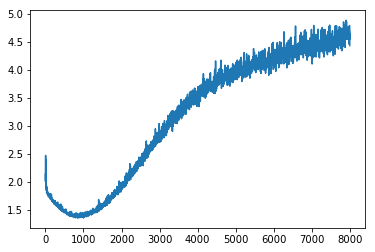

In [6]:
X, Y = getData()
    # X, Y = getBinaryData()
modelANNTheano = ANNTheano([2000, 1000])
modelANNTheano.fit(X, Y, show_fig=True)

In [ ]:
from theano.tensor.nnet import conv2d
from theano.tensor.signal import downsample

class TheanoConvPoolLayer(object):
    def __init__(self, mi, mo, fw=5, fh=5, poolsz=(2, 2)):
        # mi = input feature map size
        # mo = output feature map size
        sz = (mo, mi, fw, fh)
        W0 = init_filter(sz, poolsz)
        self.W = theano.shared(W0)
        b0 = np.zeros(mo, dtype=np.float32)
        self.b = theano.shared(b0)
        self.poolsz = poolsz
        self.params = [self.W, self.b]

    def forward(self, X):
        conv_out = conv2d(input=X, filters=self.W)
        pooled_out = downsample.max_pool_2d(
            input=conv_out,
            ds=self.poolsz,
            ignore_border=True
        )
        return T.tanh(pooled_out + self.b.dimshuffle('x', 0, 'x', 'x'))


class TheanoCNN(object):
    def __init__(self, convpool_layer_sizes, hidden_layer_sizes):
        self.convpool_layer_sizes = convpool_layer_sizes
        self.hidden_layer_sizes = hidden_layer_sizes

    def fit(self, X, Y, lr=10e-5, mu=0.99, reg=10e-7, decay=0.99999, eps=10e-3, batch_sz=30, epochs=100, show_fig=True):
        lr = np.float32(lr)
        mu = np.float32(mu)
        reg = np.float32(reg)
        decay = np.float32(decay)
        eps = np.float32(eps)

        # make a validation set
        X, Y = shuffle(X, Y)
        X = X.astype(np.float32)
        Y = Y.astype(np.int32)
        Xvalid, Yvalid = X[-1000:], Y[-1000:]
        X, Y = X[:-1000], Y[:-1000]

        # initialize convpool layers
        N, c, width, height = X.shape
        mi = c
        outw = width
        outh = height
        self.convpool_layers = []
        for mo, fw, fh in self.convpool_layer_sizes:
            layer = TheanoConvPoolLayer(mi, mo, fw, fh)
            self.convpool_layers.append(layer)
            outw = (outw - fw + 1) // 2
            outh = (outh - fh + 1) // 2
            mi = mo

        # initialize mlp layers
        K = len(set(Y))
        self.hidden_layers = []
        M1 = self.convpool_layer_sizes[-1][0]*outw*outh # size must be same as output of last convpool layer
        count = 0
        for M2 in self.hidden_layer_sizes:
            h = ANNTheanoHiddenLayer(M1, M2, count)
            self.hidden_layers.append(h)
            M1 = M2
            count += 1

        # logistic regression layer
        W, b = init_weight_and_bias(M1, K)
        self.W = theano.shared(W, 'W_logreg')
        self.b = theano.shared(b, 'b_logreg')

        # collect params for later use
        self.params = [self.W, self.b]
        for c in self.convpool_layers:
            self.params += c.params
        for h in self.hidden_layers:
            self.params += h.params

        # for momentum
        dparams = [theano.shared(np.zeros(p.get_value().shape, dtype=np.float32)) for p in self.params]

        # for rmsprop
        cache = [theano.shared(np.zeros(p.get_value().shape, dtype=np.float32)) for p in self.params]

        # set up theano functions and variables
        thX = T.tensor4('X', dtype='float32')
        thY = T.ivector('Y')
        pY = self.forward(thX)

        rcost = reg*T.sum([(p*p).sum() for p in self.params])
        cost = -T.mean(T.log(pY[T.arange(thY.shape[0]), thY])) + rcost
        prediction = self.th_predict(thX)

        cost_predict_op = theano.function(inputs=[thX, thY], outputs=[cost, prediction])

        # updates = [
        #     (c, decay*c + (np.float32(1)-decay)*T.grad(cost, p)*T.grad(cost, p)) for p, c in zip(self.params, cache)
        # ] + [
        #     (p, p + mu*dp - lr*T.grad(cost, p)/T.sqrt(c + eps)) for p, c, dp in zip(self.params, cache, dparams)
        # ] + [
        #     (dp, mu*dp - lr*T.grad(cost, p)/T.sqrt(c + eps)) for p, c, dp in zip(self.params, cache, dparams)
        # ]

        # momentum only
        updates = [
            (p, p + mu*dp - lr*T.grad(cost, p)) for p, dp in zip(self.params, dparams)
        ] + [
            (dp, mu*dp - lr*T.grad(cost, p)) for p, dp in zip(self.params, dparams)
        ]

        train_op = theano.function(
            inputs=[thX, thY],
            updates=updates
        )

        n_batches = N // batch_sz
        costs = []
        for i in range(epochs):
            X, Y = shuffle(X, Y)
            for j in range(n_batches):
                Xbatch = X[j*batch_sz:(j*batch_sz+batch_sz)]
                Ybatch = Y[j*batch_sz:(j*batch_sz+batch_sz)]

                train_op(Xbatch, Ybatch)

                if j % 20 == 0:
                    c, p = cost_predict_op(Xvalid, Yvalid)
                    costs.append(c)
                    e = error_rate(Yvalid, p)
                    print("i:", i, "j:", j, "nb:", n_batches, "cost:", c, "error rate:", e)

        if show_fig:
            plt.plot(costs)
            plt.show()

    def forward(self, X):
        Z = X
        for c in self.convpool_layers:
            Z = c.forward(Z)
        Z = Z.flatten(ndim=2)
        for h in self.hidden_layers:
            Z = h.forward(Z)
        return T.nnet.softmax(Z.dot(self.W) + self.b)

    def th_predict(self, X):
        pY = self.forward(X)
        return T.argmax(pY, axis=1)


X, Y = getImageData()
modelCNNTheano = TheanoCNN(
        convpool_layer_sizes=[(20, 5, 5), (20, 5, 5)],
        hidden_layer_sizes=[500, 300],
    )
modelCNNTheano.fit(X, Y)

In [ ]:
import tensorflow as tf

class ANNTensorflowHiddenLayer(object):
    def __init__(self, M1, M2, an_id):
        self.id = an_id
        self.M1 = M1
        self.M2 = M2
        W, b = init_weight_and_bias(M1, M2)
        self.W = tf.Variable(W.astype(np.float32))
        self.b = tf.Variable(b.astype(np.float32))
        self.params = [self.W, self.b]

    def forward(self, X):
        return tf.nn.relu(tf.matmul(X, self.W) + self.b)


class ANNTensorflow(object):
    def __init__(self, hidden_layer_sizes):
        self.hidden_layer_sizes = hidden_layer_sizes

    def fit(self, X, Y, learning_rate=10e-7, mu=0.99, decay=0.999, reg=10e-3, epochs=400, batch_sz=100, show_fig=False):
        K = len(set(Y)) # won't work later b/c we turn it into indicator

        # make a validation set
        X, Y = shuffle(X, Y)
        X = X.astype(np.float32)
        Y = y2indicator(Y).astype(np.float32)
        # Y = Y.astype(np.int32)
        Xvalid, Yvalid = X[-1000:], Y[-1000:]
        Yvalid_flat = np.argmax(Yvalid, axis=1) # for calculating error rate
        X, Y = X[:-1000], Y[:-1000]

        # initialize hidden layers
        N, D = X.shape
        
        self.hidden_layers = []
        M1 = D
        count = 0
        for M2 in self.hidden_layer_sizes:
            h = ANNTensorflowHiddenLayer(M1, M2, count)
            self.hidden_layers.append(h)
            M1 = M2
            count += 1
        W, b = init_weight_and_bias(M1, K)
        self.W = tf.Variable(W.astype(np.float32))
        self.b = tf.Variable(b.astype(np.float32))

        # collect params for later use
        self.params = [self.W, self.b]
        for h in self.hidden_layers:
            self.params += h.params

        # set up theano functions and variables
        tfX = tf.placeholder(tf.float32, shape=(None, D), name='X')
        tfT = tf.placeholder(tf.float32, shape=(None, K), name='T')
        act = self.forward(tfX)

        rcost = reg*sum([tf.nn.l2_loss(p) for p in self.params])
        cost = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(
                logits=act,
                labels=tfT
            )
        ) + rcost
        prediction = self.predict(tfX)
        train_op = tf.train.RMSPropOptimizer(learning_rate, decay=decay, momentum=mu).minimize(cost)

        n_batches = N // batch_sz
        costs = []
        init = tf.global_variables_initializer()
        with tf.Session() as session:
            session.run(init)
            for i in range(epochs):
                X, Y = shuffle(X, Y)
                for j in range(n_batches):
                    Xbatch = X[j*batch_sz:(j*batch_sz+batch_sz)]
                    Ybatch = Y[j*batch_sz:(j*batch_sz+batch_sz)]

                    session.run(train_op, feed_dict={tfX: Xbatch, tfT: Ybatch})

                    if j % 20 == 0:
                        c = session.run(cost, feed_dict={tfX: Xvalid, tfT: Yvalid})
                        costs.append(c)

                        p = session.run(prediction, feed_dict={tfX: Xvalid, tfT: Yvalid})
                        e = error_rate(Yvalid_flat, p)
                        print("i:", i, "j:", j, "nb:", n_batches, "cost:", c, "error rate:", e)
        
        if show_fig:
            plt.plot(costs)
            plt.show()

    def forward(self, X):
        Z = X
        for h in self.hidden_layers:
            Z = h.forward(Z)
        return tf.matmul(Z, self.W) + self.b

    def predict(self, X):
        act = self.forward(X)
        return tf.argmax(act, 1)


X, Y = getData()
# X, Y = getBinaryData()
modelANNTensorflow = ANNTensorflow([2000, 1000, 500])
modelANNTensorflow.fit(X, Y, show_fig=True)

In [ ]:
# differences from Theano:
# image dimensions are expected to be: N x width x height x color
# filter shapes are expected to be: filter width x filter height x input feature maps x output feature maps


def init_filter(shape, poolsz):
    w = np.random.randn(*shape) / np.sqrt(np.prod(shape[:-1]) + shape[-1]*np.prod(shape[:-2] / np.prod(poolsz)))
    return w.astype(np.float32)


class TensorflowConvPoolLayer(object):
    def __init__(self, mi, mo, fw=5, fh=5, poolsz=(2, 2)):
        # mi = input feature map size
        # mo = output feature map size
        sz = (fw, fh, mi, mo)
        W0 = init_filter(sz, poolsz)
        self.W = tf.Variable(W0)
        b0 = np.zeros(mo, dtype=np.float32)
        self.b = tf.Variable(b0)
        self.poolsz = poolsz
        self.params = [self.W, self.b]

    def forward(self, X):
        conv_out = tf.nn.conv2d(X, self.W, strides=[1, 1, 1, 1], padding='SAME')
        conv_out = tf.nn.bias_add(conv_out, self.b)
        p1, p2 = self.poolsz
        pool_out = tf.nn.max_pool(
            conv_out,
            ksize=[1, p1, p2, 1],
            strides=[1, p1, p2, 1],
            padding='SAME'
        )
        return tf.tanh(pool_out)


class CNNTensorflow(object):
    def __init__(self, convpool_layer_sizes, hidden_layer_sizes):
        self.convpool_layer_sizes = convpool_layer_sizes
        self.hidden_layer_sizes = hidden_layer_sizes

    def fit(self, X, Y, lr=10e-4, mu=0.99, reg=10e-4, decay=0.99999, eps=10e-3, batch_sz=30, epochs=3, show_fig=True):
        lr = np.float32(lr)
        mu = np.float32(mu)
        reg = np.float32(reg)
        decay = np.float32(decay)
        eps = np.float32(eps)
        K = len(set(Y))

        # make a validation set
        X, Y = shuffle(X, Y)
        X = X.astype(np.float32)
        Y = y2indicator(Y).astype(np.float32)

        Xvalid, Yvalid = X[-1000:], Y[-1000:]
        X, Y = X[:-1000], Y[:-1000]
        Yvalid_flat = np.argmax(Yvalid, axis=1) # for calculating error rate

        # initialize convpool layers
        N, width, height, c = X.shape
        mi = c
        outw = width
        outh = height
        self.convpool_layers = []
        for mo, fw, fh in self.convpool_layer_sizes:
            layer = TensorflowConvPoolLayer(mi, mo, fw, fh)
            self.convpool_layers.append(layer)
            outw = outw // 2
            outh = outh // 2
            mi = mo

        # initialize mlp layers
        self.hidden_layers = []
        M1 = self.convpool_layer_sizes[-1][0]*outw*outh # size must be same as output of last convpool layer
        count = 0
        for M2 in self.hidden_layer_sizes:
            h = ANNTensorflowHiddenLayer(M1, M2, count)
            self.hidden_layers.append(h)
            M1 = M2
            count += 1

        # logistic regression layer
        W, b = init_weight_and_bias(M1, K)
        self.W = tf.Variable(W, 'W_logreg')
        self.b = tf.Variable(b, 'b_logreg')

        # collect params for later use
        self.params = [self.W, self.b]
        for h in self.convpool_layers:
            self.params += h.params
        for h in self.hidden_layers:
            self.params += h.params

        # set up tensorflow functions and variables
        tfX = tf.placeholder(tf.float32, shape=(None, width, height, c), name='X')
        tfY = tf.placeholder(tf.float32, shape=(None, K), name='Y')
        act = self.forward(tfX)

        rcost = reg*sum([tf.nn.l2_loss(p) for p in self.params])
        cost = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(
                logits=act,
                labels=tfY
            )
        ) + rcost
        prediction = self.predict(tfX)

        train_op = tf.train.RMSPropOptimizer(lr, decay=decay, momentum=mu).minimize(cost)

        n_batches = N // batch_sz
        costs = []
        init = tf.global_variables_initializer()
        with tf.Session() as session:
            session.run(init)
            for i in range(epochs):
                X, Y = shuffle(X, Y)
                for j in range(n_batches):
                    Xbatch = X[j*batch_sz:(j*batch_sz+batch_sz)]
                    Ybatch = Y[j*batch_sz:(j*batch_sz+batch_sz)]

                    session.run(train_op, feed_dict={tfX: Xbatch, tfY: Ybatch})

                    if j % 20 == 0:
                        c = session.run(cost, feed_dict={tfX: Xvalid, tfY: Yvalid})
                        costs.append(c)

                        p = session.run(prediction, feed_dict={tfX: Xvalid, tfY: Yvalid})
                        e = error_rate(Yvalid_flat, p)
                        print("i:", i, "j:", j, "nb:", n_batches, "cost:", c, "error rate:", e)

        if show_fig:
            plt.plot(costs)
            plt.show()

    def forward(self, X):
        Z = X
        for c in self.convpool_layers:
            Z = c.forward(Z)
        Z_shape = Z.get_shape().as_list()
        Z = tf.reshape(Z, [-1, np.prod(Z_shape[1:])])
        for h in self.hidden_layers:
            Z = h.forward(Z)
        return tf.matmul(Z, self.W) + self.b

    def predict(self, X):
        pY = self.forward(X)
        return tf.argmax(pY, 1)


X, Y = getImageData()

# reshape X for tf: N x w x h x c
X = X.transpose((0, 2, 3, 1))
print("X.shape:", X.shape)

modelCNNTensorflow = CNNTensorflow(
    convpool_layer_sizes=[(20, 5, 5), (20, 5, 5)],
    hidden_layer_sizes=[500, 300],
)
modelCNNTensorflow.fit(X, Y)
